# Прогноз оттока клиентов

#### Тема проекта:
- Прогнозирование ухода клиентов из банка

#### Цель:
- Построить модель, предсказывающую уход клиента из банка, со значением F1-меры не ниже 0.59

#### Поставленные задачи:
- Исследовать предоставленные данные;
- Рассмотреть несколько моделей с учётом и без учёта дисбаланса классов;
- Выбрать модель с наилучшим значением F1-меры и AUC-ROC;
- Протестировать модель на тестовой выборке;
- Получить значение F1-меры не ниже 0.59.

#### Краткий план работы:
- [Шаг 1. Открытие и изучение файла](#Шаг-1.-Открытие-и-изучение-файла)
  - [1.1. Открытие файла](#1.1.-Открытие-файла)
  - [1.2. Проверка и изучение данных](#1.2.-Проверка-и-изучение-данных)
  - [1.3. Подготовка данных для обучения](#1.3.-Подготовка-данных-для-обучения)
- [Шаг 2. Исследование моделей](#Шаг-2.-Исследование-моделей)
  - [2.1. Обучение без учёта дисбаланса классов](#2.1.-Обучение-без-учёта-дисбаланса-классов)
  - [2.2. Обучение с учётом дисбаланса классов](#2.2.-Обучение-с-учётом-дисбаланса-классов)
   - [2.2.1. Взвешивание классов](#2.2.1.-Взвешивание-классов)
   - [2.2.2. Метод upsampling](#2.2.2.-Метод-upsampling)
- [Шаг 3. Тестирование модели](#Шаг-3.-Тестирование-модели)


#### Вывод:
- Исследованы предоставленные данные;
- Выбрана модель с наилучшими гиперпараметрами;
- На тестовой выборке удалось достигнуть значения F1-меры не ниже 0.59.

**Статус проекта**: проект завершён.

**Используемые библиотеки**: *numpy*, *pandas*, *matplotlib*, *seaborn*, *re*, *scipy*, *sklearn*, *lightgbm*

**Источник данных**: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore') 

# импорт библиотек и функция для дальнейшей работы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats as st

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

## Шаг 1. Открытие и изучение файла

Данный шаг мы разобьем на несколько этапов:  

- [**1.1. Открытие файла**](#1.1.-Открытие-файла). Выгрузка данных и изучение содержимого. План для дальнейшей предобработки.  
- [**1.2. Проверка и изучение данных**](#1.2.-Проверка-и-изучение-данных). Предобработка данных согласно намеченному плану.
- [**1.3. Подготовка данных для обучения**](#1.3.-Подготовка-данных-для-обучения). Кодирование и масштабирование признаков.

### 1.1. Открытие файла

Ознакомимся с исходным файлом: выгрузим данные и посмотрим на общую информацию.

In [2]:
# выгрузка исходных данных
data_raw = pd.read_csv('datasets/churn.csv')
data_raw.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
# вывод общей информации
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


In [4]:
# доля оставшихся - 0 и ушедших - 1 клиентов
print(data_raw['Exited'].value_counts(normalize=True))

0    0.7963
1    0.2037
Name: Exited, dtype: float64


В данных содержится **10000 строк** и **14 столбцов**.  
Ниже содержится **описание** каждого столбца и отмечены моменты, на которые нужно обратить внимание:

**ПРИЗНАКИ**
- ***RowNumber*** - индекс строки в данных  
По сути, этот столбец совпадает с **индексами** датафрейма. При обучении он не нужен, иначе модель будет рассматривать это как значимый признак и включать его в расчёты.


- ***CustomerId*** - уникальный идентификатор клиента  
Необходимо проверить, чтобы в датафрейме не было **задублированных id**. Но данный столбец тоже не понадобится для обучения.


- ***Surname*** - фамилия  
Смущает, что в строке с индексом 9 фамилия записана как **H?**. Либо это ошибка, либо это не прочитался знак.  
Для обучения колонка не потребуется, но в целом выглядит не совсем корректно.


- ***CreditScore*** - кредитный рейтинг  
Можно посмотреть на распределение кредитного рейтинга и взаимосвязь с другими показателями.


- ***Geography*** - страна проживания  
Посмотрим, по каким странам предоставлены данные.


- ***Gender*** - пол  
Проверим, чтобы в данных было только два значения *Female* и *Male*.


- ***Age*** - возраст  
Проверим, чтобы возраст был в рамках разумного (не ниже 18 и не больше, например, 90).


- ***Tenure*** - количество недвижимости у клиента  
В столбце есть пропуски. Но, возможно, это означает, что у клиента **нет недвижимости**.


- ***Balance*** - баланс на счёте  
Пропусков нет, можно проверить взаимосвязь с другими переменными. Судя по странам, скорее всего, речь идёт о **евро**. Но поскольку валюта в задании не указана, будем использовать название **"условная единица (у. е.)"**.


- ***NumOfProducts*** - количество продуктов банка, используемых клиентом  
Можно определить, сколько продуктов в среднем приходится на клиента.


- ***HasCrCard*** - наличие кредитной карты  
Проверим, чтобы имелось только два значения: 0 и 1.


- ***IsActiveMember*** - активность клиента.  
В описании сказано, что это **субъективный** показатель, введенный для демонстрации идеи (подробнее - [Bank Turnover Dataset](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)).  
Аналогично, проверим на отсутствие других значений, кроме 0 и 1.


- ***EstimatedSalary*** - предполагаемая зарплата  
Также можно посмотреть на распределение и взаимосвязь с другими переменными.


**ЦЕЛЕВОЙ ПРИЗНАК**
- ***Exited*** - факт ухода клиента  
Через *value_counts()* мы уже проверили, что в данных есть только значения 0 и 1. В выборке **ушедшими** является **20% клиентов**.

### 1.1. Вывод

- В данных содержится **10000 строк и 14 столбцов**. 
- **Целевой признак** - колонка *Exited* (клиент ушёл - 1, не ушёл - 0). В выборке **ушедшими** является **20% клиентов**, т. е. наблюдается **дисбаланс** классов.
- Присутствуют как **категориальные**, так и **количественные** переменные. В последующих шагах необходимо решить вопрос с **кодированием**.
- В колонке *Tenure* (количество недвижимости у клиента) есть **пропуски**.

### 1.2. Проверка и изучение данных

#### 1. RowNumber

Поскольку данный столбец не понадобится для обучения модели, **удалим** его из рабочего датафрейма.

In [5]:
# удаление столбца RowNumber
data = data_raw.drop('RowNumber', axis=1)
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### 2. CustomerId

Проверим колонку на наличие **дубликатов**:

In [6]:
# подсчет количества дубликатов
data['CustomerId'].duplicated().sum()

0

Дубликатов в id нет, всё в порядке. Однако для **обучения** модели этот столбец **не потребуется**: при обучении уникальный id не покажет каких-либо закономерностей, но будет восприниматься как число.

In [7]:
# удаление столбца CustomerId
data.drop('CustomerId', axis=1, inplace=True)
data.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### 3. Surname

Обычно фамилия начинается с **заглавной буквы**, после которой идут **строчные буквы**. Ранее мы уже столкнулись с подозрительной фамилией **"H?"**. Проверим фамилии по выше указанному стандартному образцу и посмотрим, есть ли ещё "подозрительные" фамилии:

In [8]:
# образец - заглавная латинская, далее строчные
pattern = '^[A-Z]\w*$'

# применеие регулярного выражения
mask = data['Surname'].str.contains(pattern)

# вывод фамилий, которые отличаются от стандартного образца
mask_invert = ~mask
invalid_names = data.loc[mask_invert]
invalid_names_list = invalid_names['Surname'].unique()
invalid_names_list

array(['H?', "O'Brien", "T'ien", "T'ang", "T'ao", "Ch'ien", "O'Sullivan",
       "Ch'iu", "K'ung", "O'Donnell", "Ts'ai", 'L?', 'De Salis', 'Hs?',
       "Ch'en", 'De Luca', 'Wentworth-Shields', "Ts'ao", "Ch'ang", "P'an",
       "Ts'ui", "P'eng", "Ch'eng", "O'Loghlen", 'Y?an', "Ch'in",
       'Li Fonti', 'Winter-Irving', "O'Neill", 'Drake-Brockman', "T'an",
       'K?', "D'Albertis", 'Le Grand', 'Y?', "O'Meara", "O'Toole",
       'Lo Duca', 'Collingridge de Tourcey', 'Le Gallienne',
       'De Bernales', "O'Connor", 'Warlow-Davies', 'De Garis', 'Hs?eh',
       'Du Cane', 'De Neeve', 'To Rot', 'Hughes-Jones', 'Cumbrae-Stewart',
       'Radcliffe-Brown', 'Edmund la Touche', 'Parry-Okeden',
       "O'Loughlin", 'Ross-Watt', 'Fleetwood-Smith', 'Barclay-Harvey',
       'Le Hunte', "O'Loghlin", "O'Callaghan", 'Ah Mouy', 'Howell-Price',
       'St Clair', 'Von Doussa', 'De Mestre', 'Marshall-Hall',
       'Hayes-Williams', "O'Kane"], dtype=object)

Какие-то фамилии имеют **другие знаки** (например, ирландские фамилии типа "O'Connor") либо **пробелы** (например, "De Neeve") - это нормально, такое может быть. Однако, встречаются и фамилии с **"?"**, как в случае с "H?".  

Выведем список фамилий с **вопросительными знаками**:

In [9]:
# проверяем фамилии в списке
pattern = '^\w*\?\w*$'
[word for word in invalid_names_list if bool(re.match(pattern = pattern, string = word))]

['H?', 'L?', 'Hs?', 'Y?an', 'K?', 'Y?', 'Hs?eh']

Для текущей задачи некорректно написанные фамилии **не так важны**. Но в реальной жизни об этой проблеме можно было бы сообщить коллегам.

Посмотрим, сколько всего уникальных фамилий в датасете:

In [10]:
# количество уникальных фамилий
print('Количество уникальных фамилий:', data['Surname'].nunique())

Количество уникальных фамилий: 2932


В данных **много однофамильцев**. Безусловно, есть вероятность нахождения закономерности в фамилиях (например, Ивановы чаще уходят из банка, чем Сидоровы). Однако мы не будем кодировать фамилии для обучения, т. к. это кажется не информативным.  

Удалим этот столбец из рабочего датафрейма:

In [11]:
# удаление столбца Surname
data.drop('Surname', axis=1, inplace=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### 4. CreditScore

Посмотрим на сводную статистику **кредитного рейтинга** по целевому признаку (выбыл клиент или нет).

Напишем функцию, которая будет выводить **сводную статистику** и строить **боксплоты** для данных, в которых нужно изучить распределение:

In [12]:
def sumstat_and_boxplot(df_name, col_name, group_by, box_title, box_ylabel, box_yticks=None):
    
    """Функция возвращает боксплот и сводную статистику по колонке с учётом разбивки по группам.
    - df_name - название датафрейма;
    - col_name - рассматриваемая колонка;
    - group_by - колонка, по которой происходит группировка;
    - box_title - указать в именительном падеже название колонки;
    - box_ylabel - указать название оси y;
    - box_yticks (необязательный параметр) - задать диапазон для оси y"""
    
    boxplot = df_name.boxplot(col_name, by=group_by, figsize=(7, 5))
    plt.title(f'Сравнение по ушедшим и действующим клиентам ({box_title})')
    plt.xlabel('Тип клиента (0 - действующий, 1 - ушедший)')
    plt.ylabel(box_ylabel)
    plt.yticks(box_yticks)
    plt.show()
    
    sumstat = df_name.groupby(group_by)[col_name].describe()
    return sumstat

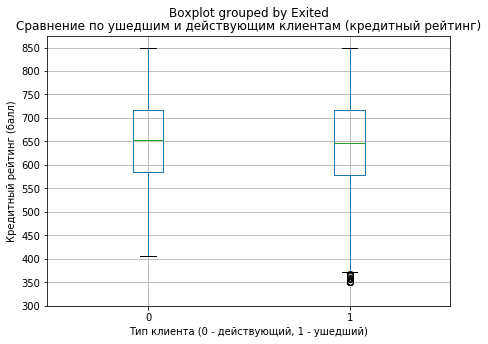

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7963.0,651.853196,95.653837,405.0,585.0,653.0,718.0,850.0
1,2037.0,645.351497,100.321503,350.0,578.0,646.0,716.0,850.0


In [13]:
# применение функции для CreditScore
sumstat_and_boxplot(data, 'CreditScore', 'Exited', 'кредитный рейтинг', 'Кредитный рейтинг (балл)', [i*50 for i in range(6, 18)])

- **Размах, среднее и медиана** для обоих типов клиентов (ушедшие и действующие) очень **похожи**.  
- Для обоих случаев **максимум - 850 баллов**. Возможно, 850 баллов в принципе является **максимумом** по этой шкале.

Посмотрим на распределение данных на **гистограмме**.  
Напишем функцию, которая будет выводить две гистограммы по колонке с учётом разбивки по группам:

In [14]:
def hist_by_groups(df_name, col_name, group_by, box_title, box_xlabel, box_xticks=None, n_bins=30):
    
    """Функция возвращает две гистограммы по колонке с учётом разбивки по группам.
    - df_name - название датафрейма;
    - col_name - рассматриваемая колонка;
    - group_by - колонка, по которой происходит группировка;
    - box_title - указать в именительном падеже название колонки;
    - box_xlabel - указать название оси x;
    - box_xticks (необязательный параметр) - задать диапазон для оси x;
    - n_bins (по умолчанию 30) - количество корзин."""
    
    # настройка размера
    plt.figure(figsize=(9,5))
    
    # построение гистограммы
    # на одном графике построим распределение данных
    sns.distplot(df_name[df_name[group_by] == 1][col_name], kde=True, label='ушедший', bins=n_bins)
    sns.distplot(df_name[df_name[group_by] == 0][col_name], kde=True, label='действующий', bins=n_bins)

    # линии среднего значения
    plt.axvline(x=df_name[df_name[group_by] == 1][col_name].mean(), color='blue', linestyle='--', label='ушедший (среднее)')
    plt.axvline(x=df_name[df_name[group_by] == 0][col_name].mean(), color='orange', linestyle='--', label='действующий (среднее)')

    plt.title('Распределение по ушедшим и действующим клиентам (' + box_title + ')')
    plt.xlabel(box_xlabel)
    plt.xticks(box_xticks, rotation=45)

    plt.legend()
    plt.grid()
    plt.show()

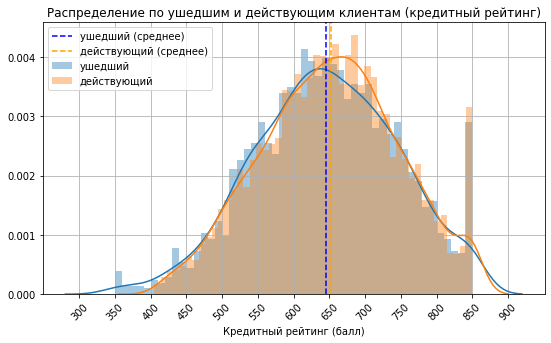

In [15]:
# применение функции для CreditScore
hist_by_groups(data, 'CreditScore', 'Exited', 'кредитный рейтинг', 'Кредитный рейтинг (балл)', [i*50 for i in range(6, 19)], 50)

- **Распределение** выборочных данных по клиентам **похоже на нормальное**: симметричность, выраженный пик в районе среднего.  
- Наблюдается **обрыв справа** и **пик** в районе **максимального рейтинга 850**. Как мы заметили ранее, возможно, 850 баллов и есть предел по шкале, поэтому выше 850 баллов оценок не существует.

Таким образом, кредитный рейтинг в целом можно описать **нормальным распределением**. Также при этом можно отметить, что в обоих случаях наблюдается пик в районе 850 баллов, что говорит о доле клиентов с **высоким рейтингом**.

#### 5. Geography

Посмотрим, по каким **странам** собраны данные и какая картина по ушедшим клиентам:

In [16]:
def count_churn(df_name, col_name):
    """Функция выводит значения колонки и долю ушедших клиентовЖ
    - df_name - наименование датафрейма;
    - col_name - наименование колонки."""
    
    # доля по значениям
    print(df_name[col_name].value_counts(normalize=True))
    print()

    # группировка
    pivot_check = df_name.pivot_table(index=col_name, columns='Exited', aggfunc='count')['Age']

    # вывод доли ушедших
    for i in range(len(pivot_check)):
        print(f'Доля ушедших (значение {pivot_check.index[i]}):', end=' ')
        print('{:.2%}'.format(pivot_check.iloc[i, 1] / pivot_check.iloc[i].sum()))  
        
    return pivot_check

In [17]:
# проверка Geography
count_churn(data, 'Geography')

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

Доля ушедших (значение France): 16.15%
Доля ушедших (значение Germany): 32.44%
Доля ушедших (значение Spain): 16.67%


Exited,0,1
Geography,,
France,4204,810
Germany,1695,814
Spain,2064,413


- В датасете **50% строк** приходятся на клиентов из **Франции**, и примерно **по 25%** на клиентов из **Германии** и **Испании**.  
- В выборке **самый большой отток** клиентов наблюдается в **Германии** - ушло около **32% от общего числа** выборочных клиентов.
- В остальных странах этот показатель на уровне **16%**.

#### 6. Gender

Посмотрим, какие значения **пола** присутствуют в выборке:

In [18]:
# проверка Gender
count_churn(data, 'Gender')

Male      0.5457
Female    0.4543
Name: Gender, dtype: float64

Доля ушедших (значение Female): 25.07%
Доля ушедших (значение Male): 16.46%


Exited,0,1
Gender,,
Female,3404,1139
Male,4559,898


- В выборке присутствует всего два значения пола: **мужчин (55%)** немного больше, чем **женщин (45%)**.  
- По выборочным данным **ушло 16%** от общего числа **мужчин** и **25%** от общего числа **женщин**.

#### 7. Age

Посмотрим на сводную статистику для **возраста** по целевому признаку (выбыл клиент или нет) и заодно проверим, значения на **адекватность** (например, возраст не ниже 18 лет и не старше 90 лет):

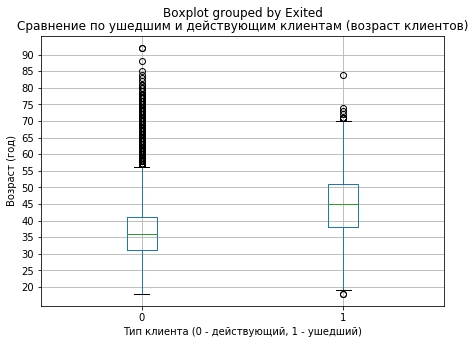

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7963.0,37.408389,10.125363,18.0,31.0,36.0,41.0,92.0
1,2037.0,44.837997,9.761562,18.0,38.0,45.0,51.0,84.0


In [19]:
# применение функции для Age
sumstat_and_boxplot(data, 'Age', 'Exited', 'возраст клиентов', 'Возраст (год)', [i*5 for i in range(4, 19)])

- По выборочным данным для **действующих** клиентов **среднее и медиана** в районе **36-37 лет**.  
- По **ушедшим** клиентам выборочное среднее и медиана несколько **выше**: в районе **45 лет**.

- Для обоих случаев **минимальный возраст** - это **18 лет**, т. е. значение адекватное.
- **Максимальный возраст** в выборке - **92 года**. Несколько больше, чем мы предполагали изначально. Но допустить, что клиентом банка может быть человек 92 лет возможно.

Посмотрим на распределение данных на **гистограмме**:

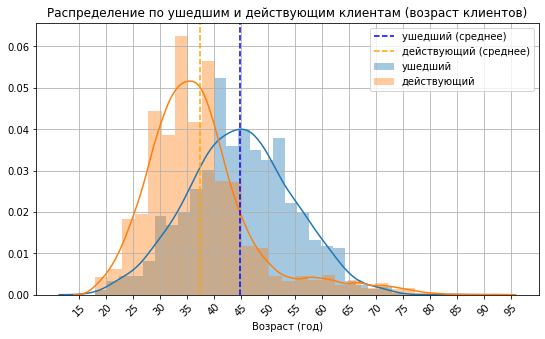

In [20]:
# применение функции для Age
hist_by_groups(data, 'Age', 'Exited', 'возраст клиентов', 'Возраст (год)', [i*5 for i in range(3, 20)], 30)

- Распределение выборочных данных также похоже на **нормальное**.
- Как было отмечено выше, распределения выборочных данных несколько **различаются**, что отражается, например, на таких показателях, как **среднее** и **медиана**.  

На первый взгляд кажется, что **действующие клиенты банка более молодые**, чем ушедшие.  
Ради интереса проверим гипотезу:
- **Нулевая гипотеза H0:** в среднем возрасте ушедших и действующих клиентов банка **разницы нет**, т. е. **возраст одинаковый**.
- **Альтернативная гипотеза H1:** в среднем возрасте ушедших и действующих клиентов банка **есть разница**, т. е. **возраст не одинаковый**.

In [21]:
# выборочные срезы
sample_exit = data.query('Exited == 1')['Age']
sample_active = data.query('Exited == 0')['Age']

# установка порога p-уровня значимости
alpha = .05

# применение теста
results = st.ttest_ind(sample_exit, sample_active, equal_var = False)

# вывод результатов
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.7127272656641046e-179
Отвергаем нулевую гипотезу


- У нас **получилось** отвергнуть нулевую гипотезу, значит, есть основания полагать, что возраст ушедших и активных клиентов всё-таки **различается**.

Итак, мы проверили, что **возраст** клиентов в датасете находится в пределах разумного - **от 18 до 92 лет**.  
**Распределение** данных **похоже на нормальное**. При этом наблюдаются **различия** в среднем возрасте **ушедших** и **действующих** клиентов.  

#### 8. Tenure

Как мы помним, в данной колонке были **пропуски**. Изначально мы предположили, что **пропуск** - это **отсутствие** недвижимости у клиента.  
Посмотрим, какие значения по количеству недвижимости есть в датасете:

In [22]:
data['Tenure'].value_counts(dropna=False)

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

В данных есть **нулевые значения**. Значит, **пропуск** может означать не только 0, но и в принципе **отсутствие информации**.  
В данных **около 9% строк** имеют **пропуск** по колонке *Tenure*.

In [23]:
data[data['Tenure'].isnull()].head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Для корректного обучения модели в признаках **не должно быть пропусков**. Примем решение **удалить строки с пропусками**.  

Но вдруг, в данные с пропусками по Tenure попало **очень много** строк с **целевым признаком**?  
Или же **непропорционально большая доля** какой-либо категории, например, клиенты с очень высокой зарплатой или жители Германии?

Предварительно нужно убедиться, что пропуски распределены более-менее равномерно. Проверим, что мы **не выбросим непропорционально много** данных какой-либо категории. 

In [24]:
def check_null(col_name, df_name=data):    
    """Функция выводит доли значений по проверяемой колонке с пропусками и без:
    - df_name (по умолчанию data) - наименование датафрейма;
    - col_name - наименование колонки для проверки."""
    
    print('---------------------------------------')
    print('Значения с пропусками:')
    print(df_name[df_name['Tenure'].isnull()][col_name].value_counts(normalize=True))
    print()
    print('Значения без пропусков:')
    print(df_name[df_name['Tenure'].notnull()][col_name].value_counts(normalize=True))
    print()

In [25]:
for col_name in ['Exited', 'Geography', 'Gender']:
    check_null(col_name)

---------------------------------------
Значения с пропусками:
0    0.79868
1    0.20132
Name: Exited, dtype: float64

Значения без пропусков:
0    0.796062
1    0.203938
Name: Exited, dtype: float64

---------------------------------------
Значения с пропусками:
France     0.510451
Spain      0.251925
Germany    0.237624
Name: Geography, dtype: float64

Значения без пропусков:
France     0.500495
Germany    0.252227
Spain      0.247278
Name: Geography, dtype: float64

---------------------------------------
Значения с пропусками:
Male      0.531353
Female    0.468647
Name: Gender, dtype: float64

Значения без пропусков:
Male      0.547135
Female    0.452865
Name: Gender, dtype: float64



- В выборках "без" и "с пропусками" примерно **одинаковая доля** по **целевому признаку** (остался - ушёл), по **странам** и по **полу**.

In [26]:
# проверка количественных признаков С пропусками
data[data['Tenure'].isnull()].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


In [27]:
# проверка количественных признаков БЕЗ пропусков
data[data['Tenure'].notnull()].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938
std,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000
50%,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000
75%,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


Данные по **количественным признакам** тоже достаточно похожи.

Итак, проверив срезы с пропусками и без, теперь можем удалить **строки с пропусками**:

In [28]:
print('Количество строк исходного датафрейма:', len(data))
data = data[data['Tenure'].notnull()]
data.reset_index(drop=True, inplace=True)
print('Количество строк после удаления пропусков:', len(data))

Количество строк исходного датафрейма: 10000
Количество строк после удаления пропусков: 9091


#### 9. Balance

Рассмотрим информацию по **балансу на счете**:

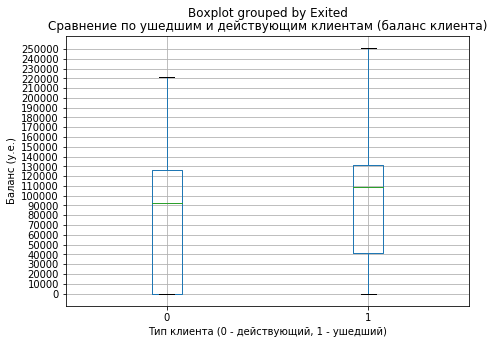

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7237.0,72824.969322,62836.651158,0.0,0.0000,92347.960,126428.380,221532.80
1,1854.0,90956.810410,58114.883718,0.0,41644.2675,109057.435,131037.045,250898.09


In [29]:
# применение функции для Balance
sumstat_and_boxplot(data, 'Balance', 'Exited', 'баланс клиента', 'Баланс (у.е.)', [i*10000 for i in range(26)])

- **Максимальное** значение по выборке (250898.09 у. е.) наблюдается у клиента, который в итоге **ушёл** из банка.  
- Клиенты с **нулевым балансом** есть среди и ушедших, и действующих.
- Среди **действующих** наблюдается **более широкий размах**, который тяготеет в меньшую сторону: граница **первой квартили** располагается на отметке 0, т. е. в 25% строк **нулевой баланс**. 

Выведем количество строк, где **баланс равен нулю**:

In [30]:
print('Количество строк с нулевым балансом:', len(data.query('Balance == 0')))
print('Ушедшие клиенты с нулевым балансом:', len(data.query('Balance == 0 and Exited == 1')))

Количество строк с нулевым балансом: 3283
Ушедшие клиенты с нулевым балансом: 452


- **Больше трети строк** из оставшихся имеют значение **баланса 0**. При этом **только 14%** из них приходится на **ушедших** клиентов.
- Значит, среди **действующих** клиентов много клиентов с **нулевым балансом**.

Посмотрим на распределение данных на гистограмме:

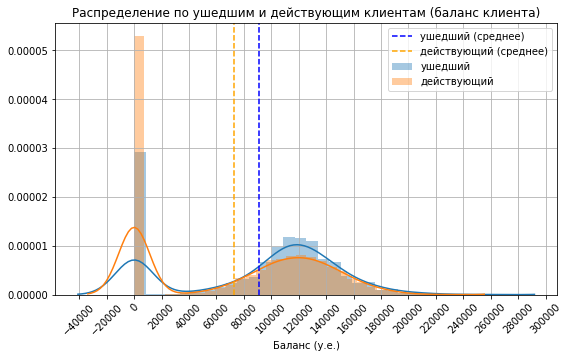

In [31]:
# применение функции для Balance
hist_by_groups(data, 'Balance', 'Exited', 'баланс клиента', 'Баланс (у.е.)', [i*20000 for i in range(-2, 16)], 30)

- На распределение очень сильно влияют **нулевые** значения баланса: наблюдается аномально большой **пик около 0** как для ушедших, так и для действующих клиентов.

Посмотрим на гистограммы **без нулевых значений**:

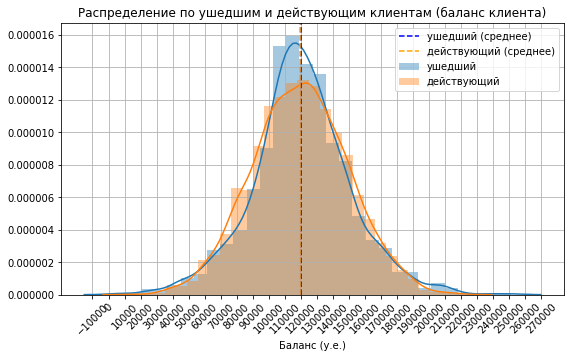

In [32]:
# срез для баланса больше 0
data_drop_balance = data.query('Balance > 0')
# применение функции для Balance
hist_by_groups(data_drop_balance, 'Balance', 'Exited', 'баланс клиента', 'Баланс (у.е.)', [i*10000 for i in range(-1, 28)], 30)

- **Без учета нулевого пика**, данные для обоих случаев достаточно **похожи** и хорошо согласуются с **нормальным распределением**: симметричность, унимодальность, пик в районе среднего.

Таким образом, в выброчных данных **треть клиентов** имеет **нулевой баланс** на счёте. Причем большая часть строк **нулевого баланса** приходится не на ушедших, а на **действующих** клиентов. Если не учитывать нулевой баланс, то распределение данных по ушедшим и действующим клиентам визуально похоже на **нормальное** с пиком в районе **среднего значения (около 120 тысяч у. е.)**.

В реальной жизни стоило бы дополнительно рассмотреть вопрос, почему в выборке так много **клиентов с нулевым балансом**, особенно среди **действующих**.

#### 10. NumOfProducts

Посмотрим, какие есть значения в переменной *NumOfProducts* (количество продуктов банка, используемых клиентом).

In [33]:
# проверка NumOfProducts
count_churn(data, 'NumOfProducts')

1    0.507865
2    0.460235
3    0.025740
4    0.006160
Name: NumOfProducts, dtype: float64

Доля ушедших (значение 1): 27.79%
Доля ушедших (значение 2): 7.70%
Доля ушедших (значение 3): 82.48%
Доля ушедших (значение 4): 100.00%


Exited,0,1
NumOfProducts,,
1,3334.0,1283.0
2,3862.0,322.0
3,41.0,193.0
4,NaN,56.0


- В выборке подавляющее **большинство** клиентов пользуется **либо 1, либо 2 продуктами банка** (более 90% клиентов выборки).
- Любопытно, что **максимальное количество продуктов** в выборке равно **4**, причем все случаи приходятся на клиентов **ушедших из банка**.
- Также высока доля **ушедших** клиентов среди тех, кто пользуется **3 продуктами банка**.  
Люди остались недовольны сервисом? Воспользовались краткосрочными выгодными программами, затем ушли из банка? Или это вообще мошенничество? Такая закономерность вызывает вопросы.

#### 11. HasCrCard

Переменная *HasCrCard* говорит о наличии либо отсутствии **кредитной карты**.

In [34]:
# проверка HasCrCard
count_churn(data, 'HasCrCard')

1    0.704983
0    0.295017
Name: HasCrCard, dtype: float64

Доля ушедших (значение 0): 20.73%
Доля ушедших (значение 1): 20.25%


Exited,0,1
HasCrCard,,
0,2126,556
1,5111,1298


- В выборке больше клиентов, у которых **есть кредитная карта** (около **70%** клиентов).
- При этом доля **ушедших** среди тех, у кого есть и нет кредитной карты, довольно одинаковая - **порядка 20%**.

#### 12. IsActiveMember

Известно, что *IsActiveMember* (активность клиента) - это **субъективный** показатель, который оценивает, можно ли клиента назвать условно активным.

In [35]:
# проверка IsActiveMember
count_churn(data, 'IsActiveMember')

1    0.515565
0    0.484435
Name: IsActiveMember, dtype: float64

Доля ушедших (значение 0): 26.84%
Доля ушедших (значение 1): 14.34%


Exited,0,1
IsActiveMember,,
0,3222,1182
1,4015,672


- В целом в выборке доля так называемых **активных** и **не активных** клиентов практически одинаковая.  
- Однако доля **ушедших** среди **активных** клиентов почти в **2 раза ниже**, чем среди **неактивных**. 

#### 13. EstimatedSalary

Рассмотрим информацию по **предполагаемой зарплате**.

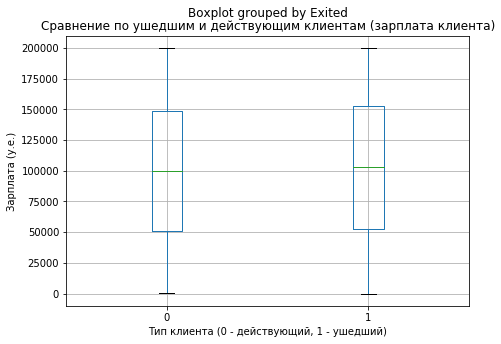

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7237.0,99713.716131,57517.666951,90.07,50839.85,99490.010,148727.42,199992.48
1,1854.0,102006.074018,58020.424361,11.58,52539.81,103210.755,152906.07,199808.10


In [36]:
# применение функции для EstimatedSalary
sumstat_and_boxplot(data, 'EstimatedSalary', 'Exited', 'зарплата клиента', 'Зарплата (у.е.)')

- В целом распределения и выборочные значения **среднего** и **медианы** для обоих случаев достаточно похожи (в район **100 тысяч у. е.**).
- **Максимальные** значение по выборке также похожи для обоих типов клиентов (около **200 тысяч у. е.**).  
- В данных **отсутствуют** клиенты с **нулевой зарплатой**.
- **Минимум** для ушедших клиентов **ниже**, чем для действующих (12 у. е. и 90 у. е. соответственно).

Посмотрим на распределение данных на гистограмме:

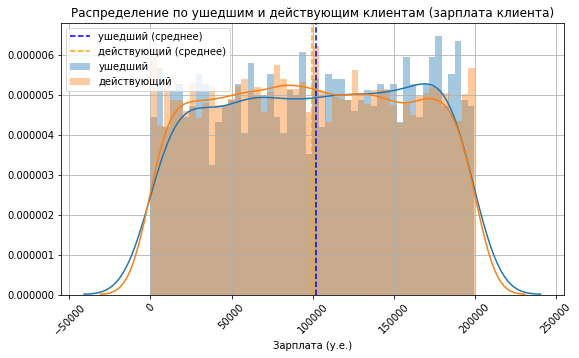

In [37]:
# применение функции для EstimatedSalary
hist_by_groups(data, 'EstimatedSalary', 'Exited', 'зарплата клиента', 'Зарплата (у.е.)', None, 50)

- Распределение данных **не нормальное**. Приблизительно с **одинаковой частотой** можно встретить людей как с **высокой** зарплатой **около 200 тысяч**, так и людей со **средней (100 тысяч)** и **низкой** зарплатой (близко расположенной к нулю).  
- В распределении **нет ярко выраженного пика**: можно сказать, что одна **половина** клиентов получает зарплату **до 100 тысяч у. е.**, а вторая - **больше 100 тысяч**. Но в среднем все получают зарплату 100 тысяч. 

#### 14. Матрица корреляций

Дополнительно посмотрим на **взаимосвязь между переменными**. Возможно, мы сможем обнаружить какую-нибудь интересную закономерность.

Для начала посмотрим на взаимосвязи для **действующих** (т. е. не ушедших) клиентов банка.  

Построим **матрицу корреляции**, **карту интенсивности** корреляции - переменных много, так будет проще сразу найти выдающиеся значения, и **график с корреляциями scatter_matrix** для визуализации корреляций.

In [38]:
# дейсвующие клиенты
# матрица с корреляциями
not_exited_matrix = data.query('Exited == 0').drop(['Exited'], axis=1)
not_exited_matrix.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.000000,0.005921,-0.008127,0.005806,0.013502,-0.005405,0.035510,0.017377
Age,0.005921,1.000000,-0.005515,0.002179,-0.022508,-0.010660,0.168641,-0.014741
Tenure,-0.008127,-0.005515,1.000000,-0.014136,0.008689,0.033408,-0.032743,0.002455
Balance,0.005806,0.002179,-0.014136,1.000000,-0.418600,-0.018309,0.015882,0.017569
NumOfProducts,0.013502,-0.022508,0.008689,-0.418600,1.000000,0.011689,-0.016971,0.009369
HasCrCard,-0.005405,-0.010660,0.033408,-0.018309,0.011689,1.000000,0.005786,-0.002216
IsActiveMember,0.035510,0.168641,-0.032743,0.015882,-0.016971,0.005786,1.000000,-0.018183
EstimatedSalary,0.017377,-0.014741,0.002455,0.017569,0.009369,-0.002216,-0.018183,1.000000


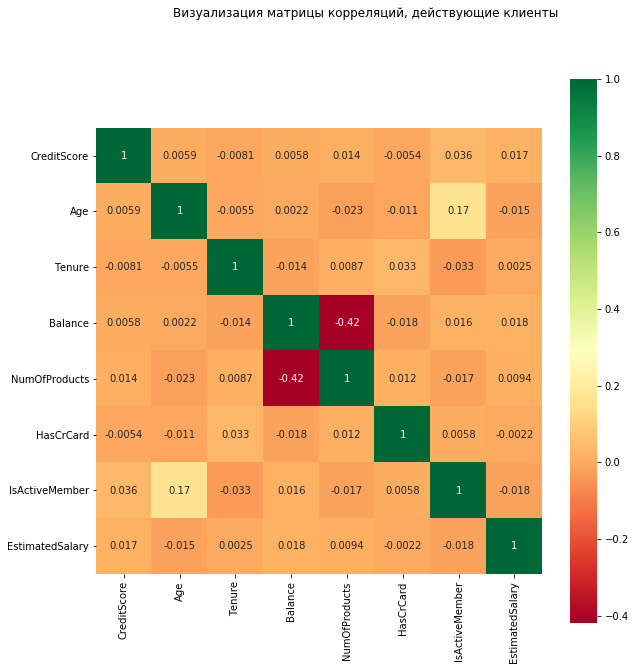

In [39]:
# карта интенсивности
plt.figure(figsize=(10,10))
sns.heatmap(not_exited_matrix.corr(), square=True, cmap='RdYlGn', annot=True)
plt.suptitle('Визуализация матрицы корреляций, действующие клиенты')
plt.show()

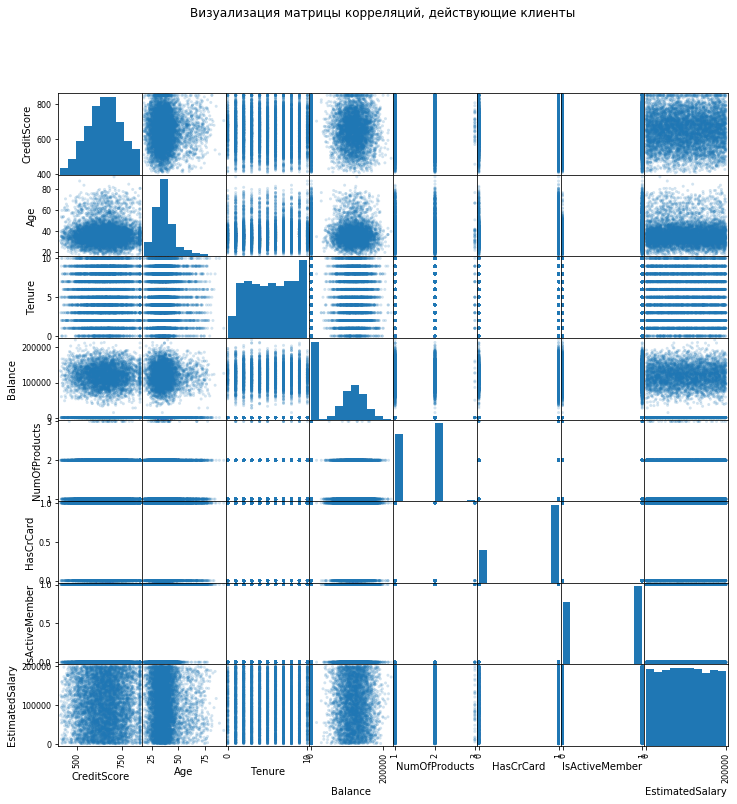

In [40]:
_ = pd.plotting.scatter_matrix(not_exited_matrix, figsize=[12, 12], alpha=0.2)
plt.suptitle('Визуализация матрицы корреляций, действующие клиенты')
plt.show()

- Матрица корреляций показывает наличие некоторой **отрицательной** взаимосвязи (значение -0.42) между **количеством продуктов** *NumOfProducts* и **балансом** *Balance*. 

- Если посмотреть на сводную статистику (ниже), видно, что в **75% случаев** с **3 продуктами** значение баланса **равно 0**.  
- Такая же проблема "перетягивания" есть и для **2 продуктов** - около **половины** случаев имеют **баланс 0**.

In [41]:
# вывод сводной статистики
# с учетом нулевых балансов
data.query('Exited == 0').groupby('NumOfProducts')['Balance'].describe()

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,3334.0,101318.960795,50655.528989,0.0,83628.7825,112678.195,135152.62,221532.80
2,3862.0,48726.041406,62060.625508,0.0,0.0000,0.000,110642.51,214346.96
3,41.0,25778.433659,51784.559966,0.0,0.0000,0.000,0.00,161591.11


Если **убрать** нулевые значения, то значения сводной статистики **по всем случаям** (1, 2 и 3 продукта) достаточно похожи.

In [42]:
# вывод сводной статистики
# без учета нулевых балансов
data.query('Exited == 0 and Balance > 0').groupby('NumOfProducts')['Balance'].describe()

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,2829.0,119405.236935,29391.054134,27288.43,99263.0900,119380.370,139480.180,221532.80
2,1568.0,120012.737188,30482.140271,14262.80,99298.6475,120429.505,140778.085,214346.96
3,9.0,117435.086667,36042.098870,49508.79,101713.8400,127122.790,141069.180,161591.11


Таким образом, была замечена тенденция, что чем **больше продуктов**, тем **больше** в выборке **строк с нулевым балансом**.  
Стоит отметить, что значений *NumOfProducts* для **3 продуктов** очень **мало** (и в принципе *NumOfProducts* - это дискретная величина с несколькими градациями). Однако следовало бы дополнительно изучить, почему при использовании **нескольких продуктов** так много **строк с нулевым балансом**.

Теперь посмотрим на **взаимосвязи** переменных для **ушедших** клиентов:

In [43]:
# ушедшие клиенты
# матрица с корреляциями
exited_matrix = data.query('Exited == 1').drop(['Exited'], axis=1)
exited_matrix.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.000000,-0.011383,0.027492,0.005068,0.001924,0.000885,-0.002935,-0.038069
Age,-0.011383,1.000000,-0.021617,-0.019155,-0.009469,-0.023139,-0.015899,-0.001318
Tenure,0.027492,-0.021617,1.000000,0.027651,0.017881,0.003367,-0.044986,0.042370
Balance,0.005068,-0.019155,0.027651,1.000000,-0.005791,-0.019608,0.012119,-0.008366
NumOfProducts,0.001924,-0.009469,0.017881,-0.005791,1.000000,-0.009271,0.048418,0.029289
HasCrCard,0.000885,-0.023139,0.003367,-0.019608,-0.009271,1.000000,-0.072170,-0.020802
IsActiveMember,-0.002935,-0.015899,-0.044986,0.012119,0.048418,-0.072170,1.000000,-0.016183
EstimatedSalary,-0.038069,-0.001318,0.042370,-0.008366,0.029289,-0.020802,-0.016183,1.000000


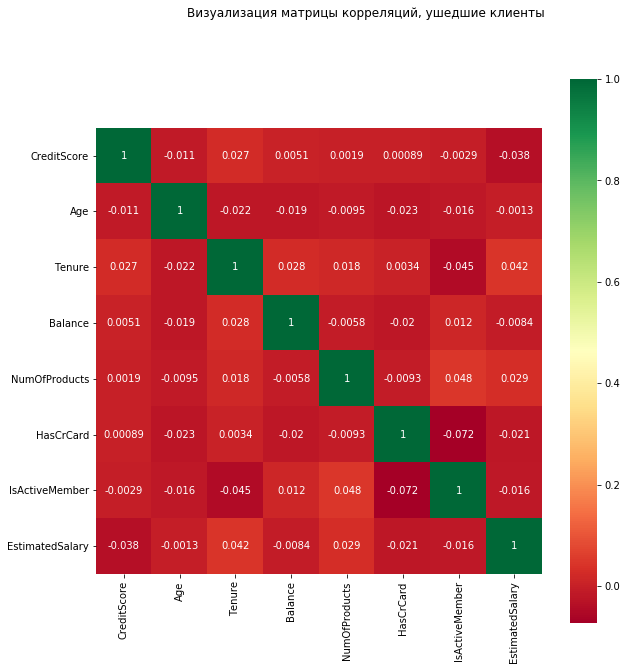

In [44]:
# карта интенсивности
plt.figure(figsize=(10,10))
sns.heatmap(exited_matrix.corr(), square=True, cmap='RdYlGn', annot=True)
plt.suptitle('Визуализация матрицы корреляций, ушедшие клиенты')
plt.show()

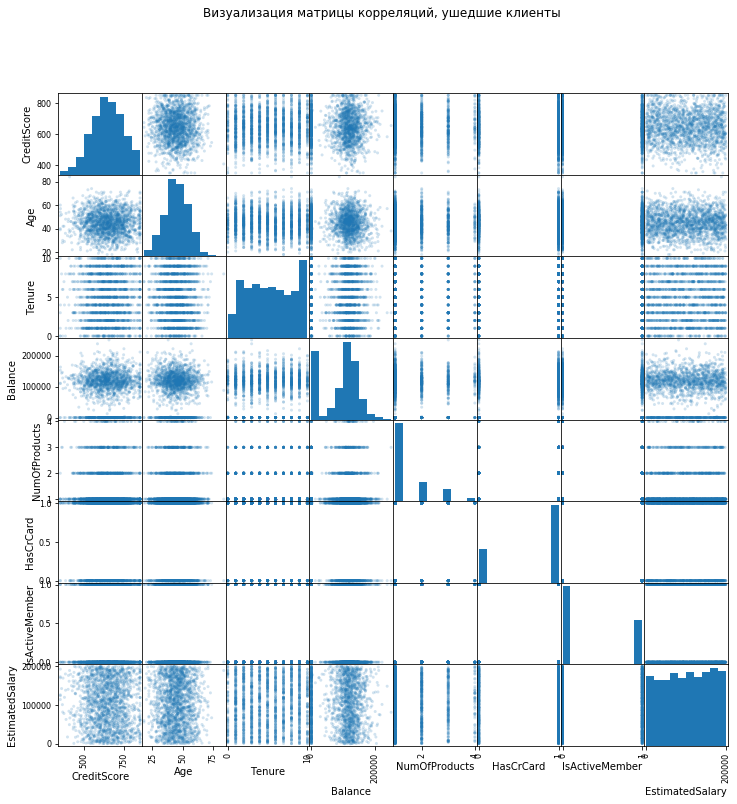

In [45]:
_ = pd.plotting.scatter_matrix(exited_matrix, figsize=[12, 12], alpha=0.2)
plt.suptitle('Визуализация матрицы корреляций, ушедшие клиенты')
plt.show()

- Каких-то новых выдающихся закономерностей обнаружено **не было**.
- Если посмотреть на ранее найденную закономерность с *NumOfProducts* и *Balance*, то такой массовой проблемы с нулевыми балансами нет, хотя в случае с **3 продуктами** около **25% имеют 0 баланс**:

In [46]:
# вывод сводной статистики
# с учетом нулевых балансов
data.query('Exited == 1').groupby('NumOfProducts')['Balance'].describe()

,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,1283.0,91429.940444,58033.829671,0.0,43088.9850,109349.290,131806.4400,238387.56
2,322.0,90381.921398,58118.870323,0.0,46069.7475,109006.295,128617.2275,210433.08
3,193.0,86022.518756,59890.261702,0.0,0.0000,106804.260,130554.5100,250898.09
4,56.0,100428.358929,53507.007572,0.0,77793.9425,117693.080,132141.8200,195238.29


Дополнительно построим матрицу корреляции **без учёта разбивки** клиентов на категории ушедшие-действующие:

In [47]:
# все клиенты
# матрица с корреляциями
all_matrix = data.drop(['Exited'], axis=1)
all_matrix.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182
Age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520
Balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351
NumOfProducts,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990
HasCrCard,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136
IsActiveMember,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049
EstimatedSalary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000


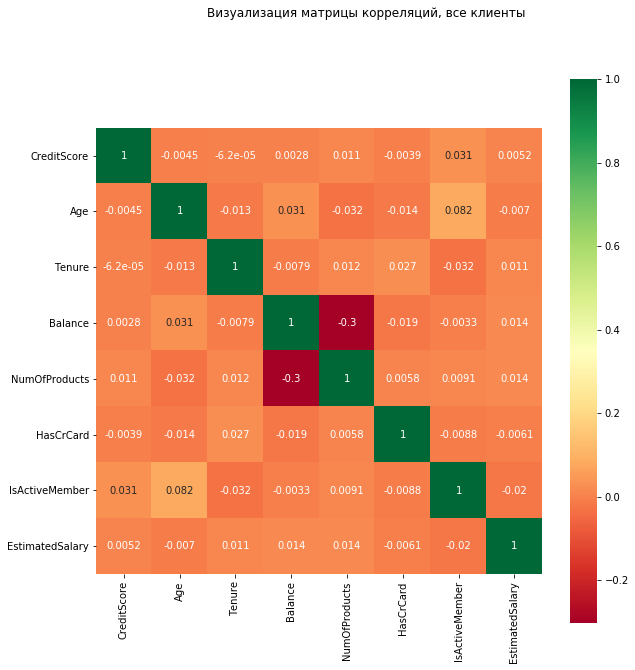

In [48]:
# карта интенсивности
plt.figure(figsize=(10,10))
sns.heatmap(all_matrix.corr(), square=True, cmap='RdYlGn', annot=True)
plt.suptitle('Визуализация матрицы корреляций, все клиенты')
plt.show()

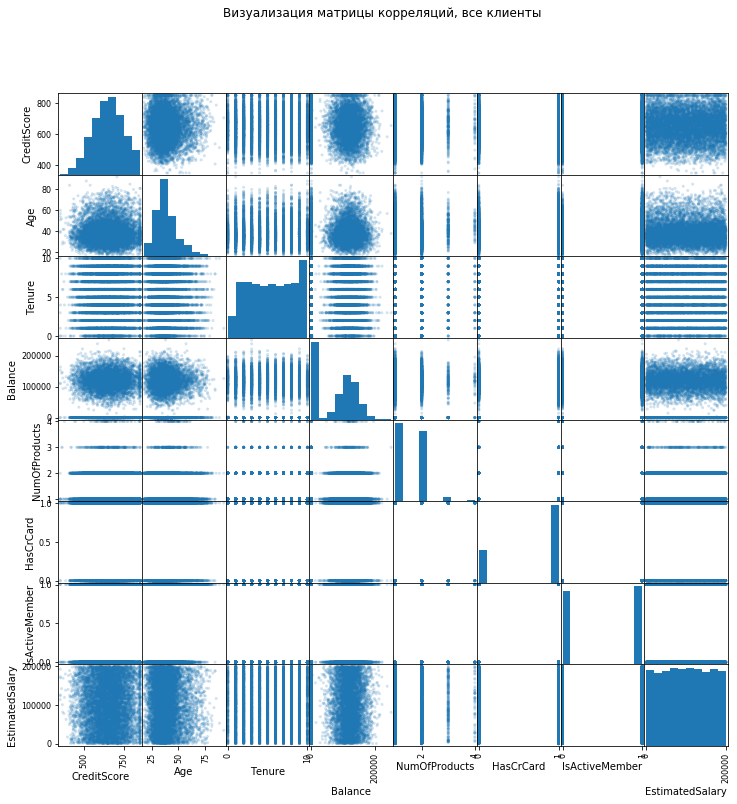

In [49]:
_ = pd.plotting.scatter_matrix(all_matrix, figsize=[12, 12], alpha=0.2)
plt.suptitle('Визуализация матрицы корреляций, все клиенты')
plt.show()

- Новых выдающихся закономерностей не обнаружено.
- Заметен эффект отрицательной корреляции между количеством продуктов *NumOfProducts* и балансом *Balance*. Но с этой закономерностью мы сталкивались при анализе действующих клиентов.

### 1.2. Вывод
- **Удалены** столбцы, которые не потребуются для обучения модели:
 - **RowNumber** — индекс строки в данных
 - **CustomerId** — уникальный идентификатор клиента
 - **Surname** - фамилия


- На следующих этапах необходимо **закодировать** столбцы:
 - **Geography** — страна проживания
 - **Gender** — пол


- Изучено **распределение количественных** переменных:
 - **CreditScore** — кредитный рейтинг. Нормальное и похожее распределение для ушедших и действующих клиентов.
 - **Age** — возраст. В обоих случаях распределение нормальное, однако есть основания полагать, что возраст ушедших и действующих клиентов **различается**.
 - **Balance** — баланс на счёте. **Больше трети** строк имеют **баланс ноль**. **14%** из них приходится на **ушедших** клиентов.  Без учета нулевых балансов, распределение для обоих случаев похоже и напоминает нормальное.
 - **EstimatedSalary** — предполагаемая зарплата. В распределении для обоих сучаев **нет** ярко выраженного пика. Приблизительно с **одинаковой частотой** можно встретить людей как с **высокой** зарплатой около **200 тысяч**, так и людей **со средней (100 тысяч)** и **низкой** зарплатой (близко расположенной **к нулю**).


- В колонке **Tenure** было принято решение **удалить пропуски (около 9% строк)**. 


- В колонке **NumOfProducts** более **90% значений** приходится либо на **1, либо на 2 продукта** банка. **Максимальное** количество продуктов в выборке **равно 4**, причем все случаи приходятся на клиентов **ушедших** из банка.


- Колонка **HasCrCard**. В выборке больше клиентов, у которых **есть кредитная карта** (около 70% клиентов). При этом доля ушедших среди тех, у кого есть и нет кредитной карты, довольно одинаковая - около 20%.


- Колонка  **IsActiveMember**. Доля так называемых активных и не активных клиентов практически **одинаковая**.
Однако доля ушедших среди активных клиентов почти **в 2 раза ниже**, чем среди неактивных.


- При исследовании **взаимосвязи** между переменными **не было** обнаружено значимых закономерностей.  
Для **действующих** клиентов было замечено, что чем **больше продуктов** используется клиентом, тем **чаще** в выборке встречаются клиенты с **нулевым балансом**. Особенно это заметно в случае с **3 продуктами**.

### 1.3. Подготовка данных для обучения

#### 1. Кодирование данных

Остановимся на более универсальной технике **One-Hot Encoding**, которая может работать в том числе с логистической регрессией.  
Как мы отметили выше, нам необходимо закодировать два столбца: *Geography* и *Gender*.

In [50]:
# использование One-Hot Encoding
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
5,645,44,8.0,113755.78,2,1,0,149756.71,1,0,1,1
6,822,50,7.0,0.00,2,1,1,10062.80,0,0,0,1
7,376,29,4.0,115046.74,4,1,0,119346.88,1,1,0,0
8,501,44,4.0,142051.07,2,0,1,74940.50,0,0,0,1
9,684,27,2.0,134603.88,1,1,1,71725.73,0,0,0,1


#### 2. Выделение признаков и целевого признака. Формирование выборок

Выделим **признаки** и **целевой признак** из данных:

In [51]:
# выделение целевого признака
target = data_ohe['Exited']
# выделение признаков
features = data_ohe.drop('Exited', axis=1)

Теперь необходимо выделить **обучающую**, **валидационную** и **тестовую** выборки.
Возьмём стандартные пропорции: под **обучающую** выборку **60%** имеющихся данных, под **валидационную** и **тестовую** по **20%**.

In [52]:
SEED = 12345

# обучающая и валидационная + тестовая выборка
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=54321)

# валидационная - valid, тестовая - test
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=54321)

print('Всего объектов в выборке:', len(data_ohe))
print('Количество объектов в обучающей выборке:', len(features_train))
print('Количество объектов в валидационной выборке:', len(features_valid))
print('Количество объектов в тестовой выборке:', len(features_test))

Всего объектов в выборке: 9091
Количество объектов в обучающей выборке: 5454
Количество объектов в валидационной выборке: 1818
Количество объектов в тестовой выборке: 1819


#### 3. Масштабирование

Поскольку в данных встречаются признаки с разными шкалами (например, возраст и зарплата), то имеет смысл сделать **масштабирование признаков**.

In [53]:
# выделение признаком для масштабирования
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']

# создание образца модели и обучение
scaler = StandardScaler()
scaler.fit(features_train[numeric])

# масштабирование 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
3989,0.625777,-1.139740,1.040677,0.593959,0.814528,1,0,0.820377,1,0,1
9044,2.057134,0.766672,1.387019,0.981733,-0.924194,1,0,-0.966028,0,0,0
3472,0.304240,-0.091213,0.347993,1.245642,-0.924194,1,0,0.022876,0,0,1
6198,0.688010,0.957313,1.733361,-1.224954,-0.924194,1,0,1.466357,0,0,0
3117,0.729499,0.766672,-1.037375,0.189547,-0.924194,1,1,-0.162237,0,0,0


### 1.3. Вывод

- Проведено **кодирование** данных в столбцах *Geography* и *Gender* с помощью техники **One-Hot Encoding**.
- Выделены **признаки** и **целевой признак *Exited***.
- Выборка разделена на **обучающую**, **тестовую** и **валидационную**.
- Проведено **масштабирование** количественных признаков.

## Шаг 1. Вывод

Мы ознакомились с полученными данными и провели предобработку:
    
### 1.1. Открытие файла
 - В исходных данных содержалось **10000 строк** и **14 столбцов**.
 - **Целевой признак** - колонка *Exited* (клиент ушёл - 1, не ушёл - 0). В выборке ушедшими является 20% клиентов (дисбаланс классов).
 - В колонке *Tenure* (количество недвижимости у клиента) были **пропуски**.
 
    
### 1.2. Проверка и изучение данных
 - Изучено распределение и особенности данных по колонкам.
 - **Удалены** колонки, которые не потребуются для обучения модели (*RowNumber*, *CustomerId*, *Surname*).
 - **Удалены** строки с **пропусками** в колонке *Tenure*.

    
### 1.3. Подготовка данных для обучения
 - Проведено **кодирование** данных в столбцах *Geography* и *Gender* с помощью техники **One-Hot Encoding**.
 - Выделены **признаки** и **целевой признак *Exited***.
 - Выборка разделена на **обучающую**, **тестовую** и **валидационную**.
 - Проведено **масштабирование** количественных признаков.

## Шаг 2. Исследование моделей

Ещё на этапе предобработки данных мы обратили внимание на **дисбаланс классов**: **ушедшими** является порядка **20% клиентов**.  
Проверим, какие результаты продемонстрируют модели с учётом и без учёта дисбаланса классов: 
- [2.1. Обучение без учёта дисбаланса классов](#2.1.-Обучение-без-учёта-дисбаланса-классов)
     - [1. Логистическая регрессия (без учёта дисбаланса)](#1.-Логистическая-регрессия-(без-учёта-дисбаланса))
     - [2. Случайный лес (без учёта дисбаланса)](#2.-Случайный-лес-(без-учёта-дисбаланса))
     - [3. Градиентный бустинг (без учёта дисбаланса)](#3.-Градиентный-бустинг-(без-учёта-дисбаланса))
     - [4. Сравнение AUC-ROC моделей (без учёта дисбаланса)](#4.-Сравнение-AUC-ROC-моделей-(без-учёта-дисбаланса))

- [2.2. Обучение с учётом дисбаланса классов](#2.2.-Обучение-с-учётом-дисбаланса-классов)
 - [2.2.1. Взвешивание классов](#2.2.1.-Взвешивание-классов)
   - [1. Логистическая регрессия (взвешивание классов)](#1.-Логистическая-регрессия-(взвешивание-классов))
   - [2. Случайный лес (взвешивание классов)](#2.-Случайный-лес-(взвешивание-классов))
   - [3. Градиентный бустинг (взвешивание классов)](#3.-Градиентный-бустинг-(взвешивание-классов))
   - [4. Сравнение AUC-ROC моделей (взвешивание классов)](#4.-Сравнение-AUC-ROC-моделей-(взвешивание-классов))
   
 - [2.2.2. Метод upsampling](#2.2.2.-Метод-upsampling)
   - [1. Логистическая регрессия (upsampling)](#1.-Логистическая-регрессия-(upsampling))
   - [2. Случайный лес (upsampling)](#2.-Случайный-лес-(upsampling))
   - [3. Градиентный бустинг (upsampling)](#3.-Градиентный-бустинг-(upsampling))
   - [4. Сравнение AUC-ROC моделей (upsampling)](#4.-Сравнение-AUC-ROC-моделей-(upsampling))

Подготовим таблицу, где будем фиксировать результаты моделей:

In [54]:
model_info = pd.DataFrame({
    'model_name': ['logistic regression', 'random forest', 'gradient boosting',
                   'logistic regression', 'random forest', 'gradient boosting',
                   'logistic regression', 'random forest', 'gradient boosting'],
    'balance_method': ['no', 'no', 'no', 'class_weight=balanced', 'class_weight=balanced', 'class_weight=balanced',
                       'upsampling', 'upsampling', 'upsampling'],
    'params': ['-', '-', '-', '-', '-', '-', '-', '-', '-'],
    'f1_valid': ['-', '-', '-', '-', '-', '-', '-', '-', '-'],
    'auc_roc_valid': ['-', '-', '-', '-', '-', '-', '-', '-', '-']
})
model_info

,model_name,balance_method,params,f1_valid,auc_roc_valid
0,logistic regression,no,-,-,-
1,random forest,no,-,-,-
2,gradient boosting,no,-,-,-
3,logistic regression,class_weight=balanced,-,-,-
4,random forest,class_weight=balanced,-,-,-
5,gradient boosting,class_weight=balanced,-,-,-
6,logistic regression,upsampling,-,-,-
7,random forest,upsampling,-,-,-
8,gradient boosting,upsampling,-,-,-


### 2.1. Обучение без учёта дисбаланса классов

На данном этапе обучим модели **без учёта дисбаланса**.  

Выберем оптимальные параметры для модели с помощью *GridSearchCV* либо *RandomizedSearchCV*, а затем проверим выбранную модель на валидационной выборке. Чтобы понять, как отработала модель, посмотрим на метрики: **accuracy**, **recall**, **precision**, **f1**.

Напишем функцию для подбора параметров с помощью *GridSearchCV* либо *RandomizedSearchCV*:

In [55]:
def search_cv_train(model_name, search_type, param_grid, random_state, features, target):
    
    """Функция выводит лучшую комбинацию для гиперпараметров модели и возвращает саму модель:
    - model_name - название модели;
    - search_type - метод подбора гиперпараметров (GridSearchCV либо RandomizedSearchCV);
    - param_grid - решётка гиперпараметров;
    - random_state - значение random_state;
    - features - значение features;
    - target - значение target."""
    
    model = model_name(random_state=random_state)
    
    if search_type == RandomizedSearchCV:
        model_cv = search_type(model, param_grid, cv=7, scoring='f1', random_state=random_state)
    else:
        model_cv = search_type(model, param_grid, cv=7, scoring='f1')
    
    model_cv.fit(features, target)
    
    print("Лучшая комбинация: {}".format(model_cv.best_params_))
    print("Лучшее значение f1: {}".format(model_cv.best_score_))
    
    return model_cv

Напишем функцию, которая будет **обучать** модель, делать **предсказания** и выводить **метрики**:

In [56]:
def fit_predict_score(model,
                      features_train_name = features_train,
                      target_train_name=target_train,
                      verbose=True):
    
    """Функция обучает модель, делает предсказания и выводит значения метрик для обучающей и валидационной выборки:
    - model - модель с настроенными гиперпараметрами;
    - features_train_name - переменная с обучающими признаками;
    - target_train_name - переменная с целевым признаком;
    - verbose (по умолчанию True) - выводить ли информацию по метрикам."""
    
    # обучение модели
    model.fit(features_train_name, target_train_name)

    # предсказания модели
    predictions_train = model.predict(features_train_name)
    predictions_valid = model.predict(features_valid)

    # расчет accuracy
    accuracy_train = accuracy_score(target_train_name, predictions_train)
    accuracy_valid = accuracy_score(target_valid, predictions_valid)

    # расчет recall
    recall_train = recall_score(target_train_name, predictions_train)
    recall_valid = recall_score(target_valid, predictions_valid)

    # расчет precision
    precision_train = precision_score(target_train_name, predictions_train)
    precision_valid = precision_score(target_valid, predictions_valid)

    # расчет f1
    f1_train = f1_score(target_train_name, predictions_train)
    f1_valid = f1_score(target_valid, predictions_valid)
       
    if verbose:
    
        print("Обучающая выборка")
        print('---------------------------------------')
        print("Accuracy:", accuracy_train)
        print("Recall:", recall_train)
        print("Precision:", precision_train)
        print("F1:", f1_train)
        print()

        print("Валидационная выборка")
        print('---------------------------------------')
        print("Accuracy:", accuracy_valid)
        print("Recall:", recall_valid)
        print("Precision:", precision_valid)
        print("F1:", f1_valid)
    
    return model, f1_train, f1_valid

### 1. Логистическая регрессия (без учёта дисбаланса)

In [57]:
%%time
# решётка с гиперпараметрами
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': np.arange(10, 26, 5),
              'solver': ['liblinear', 'saga']}

lr_cv = search_cv_train(LogisticRegression, GridSearchCV, param_grid, SEED, features_train, target_train)
print()

# логистическая регрессия с лучшими гиперпараметрами
lr = LogisticRegression(random_state=SEED, C=lr_cv.best_params_['C'],
                        penalty=lr_cv.best_params_['penalty'], solver=lr_cv.best_params_['solver'])
lr, f1_train_lr, f1_valid_lr = fit_predict_score(lr)

Лучшая комбинация: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшее значение f1: 0.3102885199582764

Обучающая выборка
---------------------------------------
Accuracy: 0.8157315731573157
Recall: 0.21203703703703702
Precision: 0.597911227154047
F1: 0.3130553656869446

Валидационная выборка
---------------------------------------
Accuracy: 0.8168316831683168
Recall: 0.22437673130193905
Precision: 0.6044776119402985
F1: 0.32727272727272727
Wall time: 4.07 s


- **Accuracy**. На валидационной выборке показатель **accuracy** - **около 82%**. Но, как мы знаем, в выборке **около 80%** - это **действующие** клиенты. Поэтому если мы укажем **константу 0**, то вероятность угадать правильный ответ также будет **80%**.

- **Recall**. Результат на уровне **0.22**. Значит, модель не очень хорошо находит положительные ответы (т. е. клиентов, ушедших из банка). Условно говоря, из 100 ушедших верно определяется только 22 клиента.

- **Precision**. Результат на уровне **0.6**. Значит, из 100 определенных моделью клиентов как "ушедших", реально ушедшими являются 60 клиентов.

- **F1**. F1-мера объединяет данные полноты и точности. В нашем случае показатель **F1** около **0.33** - это меньше того, что требуется в задании (метрика должна быть не ниже 0.59).

### 2. Случайный лес (без учёта дисбаланса)

In [58]:
%%time
# решётка с гиперпараметрами
param_grid = {'n_estimators': np.arange(30, 151, 10),
              'max_depth': np.arange(2, 9),
              'min_samples_leaf': [0.005, 0.01, 0.02]}

rf_cv = search_cv_train(RandomForestClassifier, RandomizedSearchCV, param_grid, SEED, features_train, target_train)
print()

# случайный лес с лучшими гиперпараметрами
rf = RandomForestClassifier(random_state=SEED, n_estimators=rf_cv.best_params_['n_estimators'],
                        max_depth=rf_cv.best_params_['max_depth'], min_samples_leaf=rf_cv.best_params_['min_samples_leaf'])
rf, f1_train_rf, f1_valid_rf = fit_predict_score(rf)

Лучшая комбинация: {'n_estimators': 70, 'min_samples_leaf': 0.005, 'max_depth': 8}
Лучшее значение f1: 0.5193479619100414

Обучающая выборка
---------------------------------------
Accuracy: 0.8689035570223689
Recall: 0.41388888888888886
Precision: 0.8449905482041588
F1: 0.5556246115599751

Валидационная выборка
---------------------------------------
Accuracy: 0.8608360836083608
Recall: 0.39335180055401664
Precision: 0.8068181818181818
F1: 0.5288640595903165
Wall time: 38.5 s


- По сравнению с логистической регрессией, у случайного леса гораздо **выше** значение по *точности (precision)*: на валидационной выборке из 100 ушедших клиентов реально ушедшими являются около 80 клиентов.
- Также выше показатель *f1* - он улучшился приблизительно до 0.53.

### 3. Градиентный бустинг (без учёта дисбаланса)

In [59]:
%%time
# решётка с гиперпараметрами
param_grid = {'n_estimators': np.arange(200, 451, 50),
              'min_child_weight': [0.005, 0.01, 0.02],
              'learning_rate': [0.005, 0.01, 0.1, 0.3]}

lbgm_cv = search_cv_train(LGBMClassifier, RandomizedSearchCV, param_grid, SEED, features_train, target_train)
print()

# градиентный бустинг с лучшими гиперпараметрами
lbgm = LGBMClassifier(random_state=SEED, n_estimators=lbgm_cv.best_params_['n_estimators'],
                        min_child_weight=lbgm_cv.best_params_['min_child_weight'],
                        learning_rate=lbgm_cv.best_params_['learning_rate'])
lbgm, f1_train_lbgm, f1_valid_lbgm = fit_predict_score(lbgm)

Лучшая комбинация: {'n_estimators': 300, 'min_child_weight': 0.005, 'learning_rate': 0.01}
Лучшее значение f1: 0.593925675167113

Обучающая выборка
---------------------------------------
Accuracy: 0.8927392739273927
Recall: 0.5601851851851852
Precision: 0.8461538461538461
F1: 0.6740947075208914

Валидационная выборка
---------------------------------------
Accuracy: 0.863036303630363
Recall: 0.47645429362880887
Precision: 0.7413793103448276
F1: 0.5801011804384485
Wall time: 57.4 s


- Модель демонстрирует тенденцию к **переобучению**.
- Несмотря на это, результат *f1* на валидационной выборке один из самых высоких - 0.58.

Напишем функцию для занесения результатов:

In [60]:
def fill_model_info(row_num, model_cv, f1_valid):
    """Функция заносит значения в таблицу model_info:
    - row_num - номер ряда;
    - model_cv - название модели;
    - f1_valid - значение f1 на валидационной выборке."""
    model_info.loc[row_num, 'params'] = str(model_cv.best_params_)
    model_info.loc[row_num, 'f1_valid'] = f1_valid
    return model_info

In [61]:
# списки с моделями и f1
model_list = [lr_cv, rf_cv, lbgm_cv]
f1_valid_list = [f1_valid_lr, f1_valid_rf, f1_valid_lbgm]

for i in range(3):
    model_info = fill_model_info(i, model_list[i], f1_valid_list[i])
    
model_info

,model_name,balance_method,params,f1_valid,auc_roc_valid
0,logistic regression,no,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.327273,-
1,random forest,no,"{'n_estimators': 70, 'min_samples_leaf': 0.005...",0.528864,-
2,gradient boosting,no,"{'n_estimators': 300, 'min_child_weight': 0.00...",0.580101,-
3,logistic regression,class_weight=balanced,-,-,-
4,random forest,class_weight=balanced,-,-,-
5,gradient boosting,class_weight=balanced,-,-,-
6,logistic regression,upsampling,-,-,-
7,random forest,upsampling,-,-,-
8,gradient boosting,upsampling,-,-,-


### 4. Сравнение AUC-ROC моделей (без учёта дисбаланса)

**AUC** позволяет сравнить ROC-кривые различных моделей и выбрать наилучшую. Рассчитаем метрики **AUC-ROC** и построим графики для невзвешенных моделей.

In [62]:
def roc_auc_plot(model_dict, features_valid=features_valid, target_valid=target_valid):
    
    """Функция выводит значения ROC-AUC, F1, а также ROC-кривые моделей на одном графике:
    - model_dict - словарь c наименованием модели и самой моделью;
    - features_valid - значение features тестовой выборки."""
    
    # построение графика TPR, FPR
    plt.figure(figsize=(8,6))
    
    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--', label='случайная модель')
    
    # цикл для моделей
    roc_auc_values = {}
    for model_name, model in model_dict.items():

        predictions_valid = model.predict(features_valid) # предсказания
        probabilities_valid = model.predict_proba(features_valid) # вычисление вероятностей
        probabilities_one_valid = probabilities_valid[:, 1] # вероятность того, что значение близко к 1
        fpr_model, tpr_model, thresholds_model = roc_curve(target_valid, probabilities_one_valid) # значения TPR, FPR, порогов
        auc_roc_model = roc_auc_score(target_valid, probabilities_one_valid) # значение AUC-ROC       
        roc_auc_values[model_name] = auc_roc_model # добавление значения в словарь
        
        print(f'Значение метрики AUC-ROC ({model_name}):', auc_roc_model)
        print(f'Значение метрики F1 ({model_name}):', f1_score(target_valid, predictions_valid))
        print()
             
        # ROC-кривая для выбранной модели         
        plt.plot(fpr_model, tpr_model, label=model_name)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xticks([i*0.1 for i in range(10)])

        plt.title('ROC-кривая')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        plt.legend()
    
    plt.grid()
    plt.show()
    
    return roc_auc_values

Значение метрики AUC-ROC (логистическая регрессия): 0.7536622323789823
Значение метрики F1 (логистическая регрессия): 0.32727272727272727

Значение метрики AUC-ROC (случайный лес): 0.8411318365631958
Значение метрики F1 (случайный лес): 0.5288640595903165

Значение метрики AUC-ROC (градиентный бустинг): 0.849434480975404
Значение метрики F1 (градиентный бустинг): 0.5801011804384485



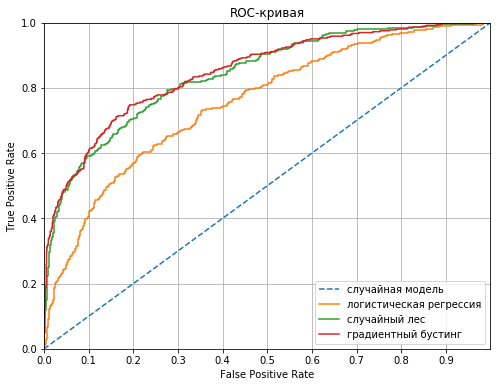

In [63]:
# выбранные модели
model_dict = roc_auc_plot({'логистическая регрессия': lr, 'случайный лес': rf, 'градиентный бустинг': lbgm})

- Для **случайного леса** и **градиентного бустинга** значение AUC-ROC практически одинаково. Это говорит о том, что при разных порогах лучше может быть то одна, то другая модель. Но в целом обе модели имеют похожую результативность.
- У **логистической регрессии** получился **наименьший** показатель AUC-ROC. По сравнению с двумя выше указанными моделями, при одинаковом уровне ложноположительных ответов (FPR) логистическая регрессия **хуже** определяет долю истинно положительных ответов.

In [64]:
# занесение данных
for index, model_name in enumerate(model_dict.keys()):
    model_info.loc[index, 'auc_roc_valid'] = model_dict[model_name]
model_info

,model_name,balance_method,params,f1_valid,auc_roc_valid
0,logistic regression,no,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.327273,0.753662
1,random forest,no,"{'n_estimators': 70, 'min_samples_leaf': 0.005...",0.528864,0.841132
2,gradient boosting,no,"{'n_estimators': 300, 'min_child_weight': 0.00...",0.580101,0.849434
3,logistic regression,class_weight=balanced,-,-,-
4,random forest,class_weight=balanced,-,-,-
5,gradient boosting,class_weight=balanced,-,-,-
6,logistic regression,upsampling,-,-,-
7,random forest,upsampling,-,-,-
8,gradient boosting,upsampling,-,-,-


### 2.1. Вывод

- В выборке наблюдается **дисбаланс классов**: **ушедшими** является около **20% клиентов**.   


- Проведено обучение моделей **без учёта дисбаланса**:
 - **Логистическая регрессия**:
    - **Accuracy**. На валидационной выборке показатель **accuracy** - **около 82%**. Но, как мы знаем, в выборке **около 80%** - это **действующие** клиенты. Поэтому если мы укажем **константу 0**, то вероятность угадать правильный ответ также будет **80%**.
    - **Recall**. Результат на уровне **0.22**. Значит, модель не очень хорошо находит положительные ответы (т. е. клиентов, ушедших из банка). Условно говоря, из 100 ушедших верно определяется только 22 клиента.
    - **Precision**. Результат на уровне **0.6**. Значит, из 100 определенных моделью клиентов как "ушедших", реально ушедшими являются 60 клиентов.
    - **F1**. F1-мера объединяет данные полноты и точности. В нашем случае показатель **F1** около **0.33** - это меньше того, что требуется в задании (метрика должна быть не ниже 0.59).
  - **Случайный лес**:
    - По сравнению с логистической регрессией, у случайного леса гораздо **выше** значение по *точности (precision)*: на валидационной выборке из 100 ушедших клиентов реально ушедшими являются около 80 клиентов.
    - Также выше показатель *f1* - он улучшился приблизительно до 0.53.
 - **Градиентный бустинг**:
    - Модель демонстрирует тенденцию к **переобучению**.
    - Несмотря на это, результат *f1* на валидационной выборке один из самых высоких - 0.58.


- Для моделей рассчитана метрика **AUC-ROC**:
    - Для **случайного леса** и **градиентного бустинга** значение AUC-ROC практически одинаково. Это говорит о том, что при разных порогах лучше может быть то одна, то другая модель. Но в целом обе модели имеют похожую результативность.
    - У **логистической регрессии** получился **наименьший** показатель AUC-ROC. По сравнению с двумя выше указанными моделями, при одинаковом уровне ложноположительных ответов (FPR) логистическая регрессия **хуже** определяет долю истинно положительных ответов.

### 2.2. Обучение с учётом дисбаланса классов

Для борьбы с дисбалансом есть разные методы, например: **взвешивание классов, upsampling** и **downsampling**.  
Посмотрим, какие результаты будут при использовании **взвешивания классов**.  

### 2.2.1. Взвешивание классов

Укажем в решётке дополнительный гиперпараметр *class_weight* с вариантом *balanced*:

### 1. Логистическая регрессия (взвешивание классов)

In [65]:
%%time
# решётка с гиперпараметрами
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': np.arange(10, 26, 5),
              'solver': ['liblinear', 'saga'],
              'class_weight': [None, 'balanced']}

lr_cv = search_cv_train(LogisticRegression, GridSearchCV, param_grid, SEED, features_train, target_train)
print()

# модель с лучшими гиперпараметрами
lr = LogisticRegression(random_state=SEED, C=lr_cv.best_params_['C'],
                        penalty=lr_cv.best_params_['penalty'], solver=lr_cv.best_params_['solver'],
                        class_weight=lr_cv.best_params_['class_weight'])
lr, f1_train_lr, f1_valid_lr = fit_predict_score(lr)

Лучшая комбинация: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Лучшее значение f1: 0.4977322106487504

Обучающая выборка
---------------------------------------
Accuracy: 0.7189218921892189
Recall: 0.7092592592592593
Precision: 0.3858942065491184
F1: 0.499836867862969

Валидационная выборка
---------------------------------------
Accuracy: 0.7079207920792079
Recall: 0.6731301939058172
Precision: 0.3704268292682927
F1: 0.4778761061946903
Wall time: 10 s


- В прежнюю комбинацию гиперпараметров был выбран *class_weight* с вариантом *balanced*.
- В результате этого значение *f1* на валидационной выборке выросло с **0.33** до **0.48**.

### 2. Случайный лес (взвешивание классов)

In [66]:
%%time
# решётка с гиперпараметрами
param_grid = {'n_estimators': np.arange(30, 151, 10),
              'max_depth': np.arange(2, 9),
              'min_samples_leaf': [0.005, 0.01, 0.02],
              'class_weight': [None, 'balanced']}

rf_cv = search_cv_train(RandomForestClassifier, RandomizedSearchCV, param_grid, SEED, features_train, target_train)
print()

# модель с лучшими гиперпараметрами
rf = RandomForestClassifier(random_state=SEED, n_estimators=rf_cv.best_params_['n_estimators'],
                        max_depth=rf_cv.best_params_['max_depth'], min_samples_leaf=rf_cv.best_params_['min_samples_leaf'],
                        class_weight=rf_cv.best_params_['class_weight'])
rf, f1_train_rf, f1_valid_rf = fit_predict_score(rf)

Лучшая комбинация: {'n_estimators': 110, 'min_samples_leaf': 0.01, 'max_depth': 7, 'class_weight': 'balanced'}
Лучшее значение f1: 0.5660953348510515

Обучающая выборка
---------------------------------------
Accuracy: 0.7962962962962963
Recall: 0.7731481481481481
Precision: 0.49088771310993534
F1: 0.6005034160373965

Валидационная выборка
---------------------------------------
Accuracy: 0.7777777777777778
Recall: 0.6731301939058172
Precision: 0.45935727788279773
F1: 0.5460674157303371
Wall time: 39.3 s


- Результат на валидационной выборке также немного улучшился с **0.53** до **0.55**.
- С учётом дисбаланса была предложена другая комбинация гиперпараметров: ***'n_estimators': 110, 'min_samples_leaf': 0.01, 'max_depth': 7, 'class_weight': 'balanced'***

### 3. Градиентный бустинг (взвешивание классов)

In [67]:
%%time
# решётка с гиперпараметрами
param_grid = {'n_estimators': np.arange(200, 451, 50),
              'min_child_weight': [0.005, 0.01, 0.02],
              'learning_rate': [0.005, 0.01, 0.1, 0.3],
              'class_weight': [None, 'balanced']}

lbgm_cv = search_cv_train(LGBMClassifier, RandomizedSearchCV, param_grid, SEED, features_train, target_train)
print()

# модель с лучшими гиперпараметрами
lbgm = LGBMClassifier(random_state=SEED, n_estimators=lbgm_cv.best_params_['n_estimators'],
                        min_child_weight=lbgm_cv.best_params_['min_child_weight'],
                        learning_rate=lbgm_cv.best_params_['learning_rate'],
                        class_weight=lbgm_cv.best_params_['class_weight'])
lbgm, f1_train_lbgm, f1_valid_lbgm = fit_predict_score(lbgm)

Лучшая комбинация: {'n_estimators': 200, 'min_child_weight': 0.02, 'learning_rate': 0.01, 'class_weight': 'balanced'}
Лучшее значение f1: 0.6124666422662418

Обучающая выборка
---------------------------------------
Accuracy: 0.8395672900623395
Recall: 0.8277777777777777
Precision: 0.5647504737839545
F1: 0.6714232069095004

Валидационная выборка
---------------------------------------
Accuracy: 0.801980198019802
Recall: 0.7091412742382271
Precision: 0.5009784735812133
F1: 0.5871559633027523
Wall time: 54.2 s


- Результат практически не изменился, *f1* осталось на уровне **0.59**.
- Комбинация изменилась, и в неё также было рекомендовано включить *'class_weight': 'balanced'*.

In [68]:
# занесение результатов
# Series с моделями и f1
model_series = pd.Series([lr_cv, rf_cv, lbgm_cv])
model_series.index += 3
f1_valid_series = pd.Series([f1_valid_lr, f1_valid_rf, f1_valid_lbgm])
f1_valid_series.index += 3

for i in range(3, 6):
    model_info = fill_model_info(i, model_series[i], f1_valid_series[i])
    
model_info

,model_name,balance_method,params,f1_valid,auc_roc_valid
0,logistic regression,no,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.327273,0.753662
1,random forest,no,"{'n_estimators': 70, 'min_samples_leaf': 0.005...",0.528864,0.841132
2,gradient boosting,no,"{'n_estimators': 300, 'min_child_weight': 0.00...",0.580101,0.849434
3,logistic regression,class_weight=balanced,"{'C': 10, 'class_weight': 'balanced', 'penalty...",0.477876,-
4,random forest,class_weight=balanced,"{'n_estimators': 110, 'min_samples_leaf': 0.01...",0.546067,-
5,gradient boosting,class_weight=balanced,"{'n_estimators': 200, 'min_child_weight': 0.02...",0.587156,-
6,logistic regression,upsampling,-,-,-
7,random forest,upsampling,-,-,-
8,gradient boosting,upsampling,-,-,-


### 4. Сравнение AUC-ROC моделей (взвешивание классов)

Значение метрики AUC-ROC (логистическая регрессия): 0.7591320533027109
Значение метрики F1 (логистическая регрессия): 0.4778761061946903

Значение метрики AUC-ROC (случайный лес): 0.8306503896558215
Значение метрики F1 (случайный лес): 0.5460674157303371

Значение метрики AUC-ROC (градиентный бустинг): 0.8446091749258998
Значение метрики F1 (градиентный бустинг): 0.5871559633027523



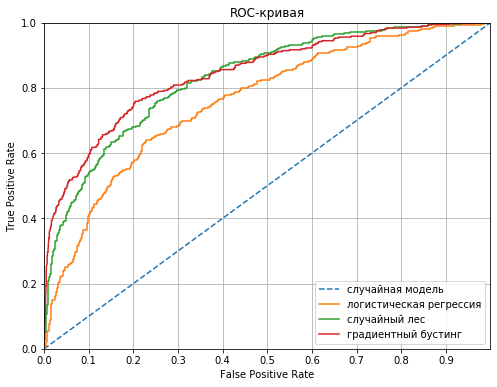

In [69]:
# выбранные модели
model_dict = roc_auc_plot({'логистическая регрессия': lr, 'случайный лес': rf, 'градиентный бустинг': lbgm})

- При учёте дисбаланса классов с помощью *'class_weight': 'balanced'* значение AUC-ROC для моделей практически не изменилось.

In [70]:
# занесение данных
for index, model_name in enumerate(model_dict.keys(), start=3):
    model_info.loc[index, 'auc_roc_valid'] = model_dict[model_name]
model_info

,model_name,balance_method,params,f1_valid,auc_roc_valid
0,logistic regression,no,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.327273,0.753662
1,random forest,no,"{'n_estimators': 70, 'min_samples_leaf': 0.005...",0.528864,0.841132
2,gradient boosting,no,"{'n_estimators': 300, 'min_child_weight': 0.00...",0.580101,0.849434
3,logistic regression,class_weight=balanced,"{'C': 10, 'class_weight': 'balanced', 'penalty...",0.477876,0.759132
4,random forest,class_weight=balanced,"{'n_estimators': 110, 'min_samples_leaf': 0.01...",0.546067,0.83065
5,gradient boosting,class_weight=balanced,"{'n_estimators': 200, 'min_child_weight': 0.02...",0.587156,0.844609
6,logistic regression,upsampling,-,-,-
7,random forest,upsampling,-,-,-
8,gradient boosting,upsampling,-,-,-


### 2.2.2. Метод upsampling

Посмотрим, как на результаты повлияет другая техника - **upsampling**, суть которой в том, чтобы сделать более редкие классы **не редкими**. То есть чтобы 0 и 1 встречались в выборке приблизительно одинаково.

Сначала напишем функцию для **upsample**:

In [71]:
# функция для upsample
def upsample(features, target, repeat, random_state):
    """Функция возвращает признаки и целевой признак, где учитывается дисбаланс классов с помощью upsample:
    - features - исходные признаки;
    - target - исходный целевой признак;
    - repeat - количество повторений;
    - random_state - значение random_state."""
    
    features_zeros = features[target == 0] # признаки с таргет 0
    features_ones = features[target == 1] # признаки с таргет 1
    target_zeros = target[target == 0] # целевой признак 0
    target_ones = target[target == 1] # целевой признак 1

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) # увеличиваем признаки с 1
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) # увеличиваем таргеты с 1
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=random_state) # перемешиваем данные
    
    return features_upsampled, target_upsampled

Поскольку в исходной выборке положительные ответы встречаются в 4 раза реже, **увеличим** количество положительных ответов **в 4 раза**.

In [72]:
# увеличение положительных ответов
features_upsampled, target_upsampled = upsample(features_train, target_train, 4, SEED)

### 1. Логистическая регрессия (upsampling)

In [73]:
%%time
# решётка с гиперпараметрами
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': np.arange(10, 26, 5),
              'solver': ['liblinear', 'saga']}

lr_cv = search_cv_train(LogisticRegression, GridSearchCV, param_grid, SEED, features_upsampled, target_upsampled)
print()

# модель с лучшими гиперпараметрами
lr = LogisticRegression(random_state=SEED, C=lr_cv.best_params_['C'],
                        penalty=lr_cv.best_params_['penalty'], solver=lr_cv.best_params_['solver'])
lr, f1_train_lr, f1_valid_lr = fit_predict_score(lr, features_upsampled, target_upsampled)

Лучшая комбинация: {'C': 15, 'penalty': 'l1', 'solver': 'saga'}
Лучшее значение f1: 0.7115602311329008

Обучающая выборка
---------------------------------------
Accuracy: 0.7152058891189326
Recall: 0.7046296296296296
Precision: 0.7172478793590952
F1: 0.7108827650630546

Валидационная выборка
---------------------------------------
Accuracy: 0.7095709570957096
Recall: 0.6731301939058172
Precision: 0.3721286370597244
F1: 0.47928994082840237
Wall time: 6.67 s


- Были предложены другие гиперпараметры: ***'C': 15, 'penalty': 'l1', 'solver': 'saga'***.
- В данной технике результат *f1* остался на уровне **0.48**.

### 2. Случайный лес (upsampling)

In [74]:
%%time
# решётка с гиперпараметрами
param_grid = {'n_estimators': np.arange(30, 151, 10),
              'max_depth': np.arange(2, 9),
              'min_samples_leaf': [0.005, 0.01, 0.02]}

rf_cv = search_cv_train(RandomForestClassifier, RandomizedSearchCV, param_grid, SEED, features_upsampled, target_upsampled)
print()

# модель с лучшими гиперпараметрами
rf = RandomForestClassifier(random_state=SEED, n_estimators=rf_cv.best_params_['n_estimators'],
                        max_depth=rf_cv.best_params_['max_depth'], min_samples_leaf=rf_cv.best_params_['min_samples_leaf'])
rf, f1_train_rf, f1_valid_rf = fit_predict_score(rf, features_upsampled, target_upsampled)

Лучшая комбинация: {'n_estimators': 70, 'min_samples_leaf': 0.005, 'max_depth': 8}
Лучшее значение f1: 0.7943004503086389

Обучающая выборка
---------------------------------------
Accuracy: 0.8142397055440533
Recall: 0.7953703703703704
Precision: 0.8245740340772738
F1: 0.809708966654884

Валидационная выборка
---------------------------------------
Accuracy: 0.7931793179317932
Recall: 0.6869806094182825
Precision: 0.48532289628180036
F1: 0.5688073394495412
Wall time: 50 s


- Результат *f1* на валидационной выборке улучшился и вырос до **0.57**.
- Однако при этом модель ещё сильнее переобучилась: в обучающей выборке показатель *f1* вырос до **0.81**.

### 3. Градиентный бустинг (upsampling)

In [75]:
%%time
# решётка с гиперпараметрами
param_grid = {'n_estimators': np.arange(200, 451, 50),
              'min_child_weight': [0.005, 0.01, 0.02],
              'learning_rate': [0.005, 0.01, 0.1, 0.3]}

lbgm_cv = search_cv_train(LGBMClassifier, RandomizedSearchCV, param_grid, SEED, features_upsampled, target_upsampled)
print()

# модель с лучшими гиперпараметрами
lbgm = LGBMClassifier(random_state=SEED, n_estimators=lbgm_cv.best_params_['n_estimators'],
                        min_child_weight=lbgm_cv.best_params_['min_child_weight'],
                        learning_rate=lbgm_cv.best_params_['learning_rate'])
lbgm, f1_train_lbgm, f1_valid_lbgm = fit_predict_score(lbgm, features_upsampled, target_upsampled)

Лучшая комбинация: {'n_estimators': 450, 'min_child_weight': 0.01, 'learning_rate': 0.3}
Лучшее значение f1: 0.9606725479459143

Обучающая выборка
---------------------------------------
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1: 1.0

Валидационная выборка
---------------------------------------
Accuracy: 0.8536853685368537
Recall: 0.5263157894736842
Precision: 0.6666666666666666
F1: 0.5882352941176471
Wall time: 1min 16s


- Результат незначительно вырос, *f1* на валидационной выборке достигло значения **0.59**.
- Обратная сторона процесса, как и у случайного леса, сильное **переобучение** модели: в обучающей выборке модель полностью выучила все результаты.

In [76]:
# занесение результатов
# Series с моделями и f1
model_series = pd.Series([lr_cv, rf_cv, lbgm_cv])
model_series.index += 6

f1_valid_series = pd.Series([f1_valid_lr, f1_valid_rf, f1_valid_lbgm])
f1_valid_series.index += 6

for i in range(6, 9):
    model_info = fill_model_info(i, model_series[i], f1_valid_series[i])
    
model_info

,model_name,balance_method,params,f1_valid,auc_roc_valid
0,logistic regression,no,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.327273,0.753662
1,random forest,no,"{'n_estimators': 70, 'min_samples_leaf': 0.005...",0.528864,0.841132
2,gradient boosting,no,"{'n_estimators': 300, 'min_child_weight': 0.00...",0.580101,0.849434
3,logistic regression,class_weight=balanced,"{'C': 10, 'class_weight': 'balanced', 'penalty...",0.477876,0.759132
4,random forest,class_weight=balanced,"{'n_estimators': 110, 'min_samples_leaf': 0.01...",0.546067,0.83065
5,gradient boosting,class_weight=balanced,"{'n_estimators': 200, 'min_child_weight': 0.02...",0.587156,0.844609
6,logistic regression,upsampling,"{'C': 15, 'penalty': 'l1', 'solver': 'saga'}",0.47929,-
7,random forest,upsampling,"{'n_estimators': 70, 'min_samples_leaf': 0.005...",0.568807,-
8,gradient boosting,upsampling,"{'n_estimators': 450, 'min_child_weight': 0.01...",0.588235,-


### 4. Сравнение AUC-ROC моделей (upsampling)

Значение метрики AUC-ROC (логистическая регрессия): 0.7590902263787198
Значение метрики F1 (логистическая регрессия): 0.47928994082840237

Значение метрики AUC-ROC (случайный лес): 0.8393275751601305
Значение метрики F1 (случайный лес): 0.5688073394495412

Значение метрики AUC-ROC (градиентный бустинг): 0.8197905992087107
Значение метрики F1 (градиентный бустинг): 0.5882352941176471



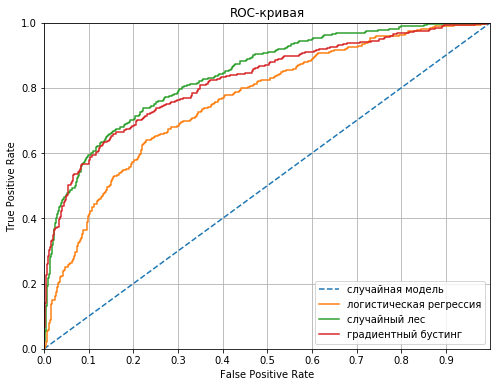

In [77]:
# выбранные модели
model_dict = roc_auc_plot({'логистическая регрессия': lr, 'случайный лес': rf, 'градиентный бустинг': lbgm})

- При учёте дисбаланса классов с помощью *upsample* значение AUC-ROC для моделей практически не изменилось.
- Наилучший результат AUC-ROC показал **случайный лес** - при большинстве порогов он лучше в т. ч. градиентного бустинга.

In [78]:
# занесение данных
for index, model_name in enumerate(model_dict.keys(), start=6):
    model_info.loc[index, 'auc_roc_valid'] = model_dict[model_name]
model_info

,model_name,balance_method,params,f1_valid,auc_roc_valid
0,logistic regression,no,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.327273,0.753662
1,random forest,no,"{'n_estimators': 70, 'min_samples_leaf': 0.005...",0.528864,0.841132
2,gradient boosting,no,"{'n_estimators': 300, 'min_child_weight': 0.00...",0.580101,0.849434
3,logistic regression,class_weight=balanced,"{'C': 10, 'class_weight': 'balanced', 'penalty...",0.477876,0.759132
4,random forest,class_weight=balanced,"{'n_estimators': 110, 'min_samples_leaf': 0.01...",0.546067,0.83065
5,gradient boosting,class_weight=balanced,"{'n_estimators': 200, 'min_child_weight': 0.02...",0.587156,0.844609
6,logistic regression,upsampling,"{'C': 15, 'penalty': 'l1', 'solver': 'saga'}",0.47929,0.75909
7,random forest,upsampling,"{'n_estimators': 70, 'min_samples_leaf': 0.005...",0.568807,0.839328
8,gradient boosting,upsampling,"{'n_estimators': 450, 'min_child_weight': 0.01...",0.588235,0.819791


### 2.2. Вывод

- Для борьбы с **дисбалансом классов** были использованы следующие методы:
 - **Взвешивание классов** - указание в гиперпараметров ***class_weight: balanced***.
 - **Метод upsample** - увеличение доли более редких положительных ответов.
- В результате все модели показали **увеличение** значения *f1*.
- В случае с **upsample** обратным эффектом было то, что модель сильно **переобучалась** - *f1* на обучающей выборке было заметно выше, чем на валидационной.
- Значение **AUC-ROC** осталось практически без изменений.

## Шаг 2. Вывод

- Были рассмотрены результаты **без учёта** и **с учётом** дисбаланса классов.
- Наилучшие результаты по *f1* были получены **при учёте дисбаланса классов**.
- В качестве устранения дисбаланса классов было рассмотрено два метода:
 - **Взвешивание классов** - указание в гиперпараметрах ***'class_weight = balanced'***
 - **Upsampling** - увеличение количества редких элементов, в нашем случае в 4 раза

- В случае с **upsample** обратным эффектом было то, что модель сильно **переобучалась** - *f1* на обучающей выборке было заметно выше, чем на валидационной.
- Учёт баланса классов практически не повлиял на значения *AUC-ROC*.
- Наилучшие результаты во всех случаях продемонстрировала модель **градиентного бустинга**. Однако при методе *upsample* модель градиентного бустинга практически дословно выучивала ответы обучающей выборки.
- В качестве модели для финального тестирования выберем **градиентный бустинг** с гиперпараметрами: ***'n_estimators': 200, 'min_child_weight': 0.02, 'learning_rate': 0.01, 'class_weight': 'balanced'***.

In [79]:
# сортировка по наилучшему значению f1
model_info.sort_values(by='f1_valid', ascending=False)

,model_name,balance_method,params,f1_valid,auc_roc_valid
8,gradient boosting,upsampling,"{'n_estimators': 450, 'min_child_weight': 0.01...",0.588235,0.819791
5,gradient boosting,class_weight=balanced,"{'n_estimators': 200, 'min_child_weight': 0.02...",0.587156,0.844609
2,gradient boosting,no,"{'n_estimators': 300, 'min_child_weight': 0.00...",0.580101,0.849434
7,random forest,upsampling,"{'n_estimators': 70, 'min_samples_leaf': 0.005...",0.568807,0.839328
4,random forest,class_weight=balanced,"{'n_estimators': 110, 'min_samples_leaf': 0.01...",0.546067,0.83065
1,random forest,no,"{'n_estimators': 70, 'min_samples_leaf': 0.005...",0.528864,0.841132
6,logistic regression,upsampling,"{'C': 15, 'penalty': 'l1', 'solver': 'saga'}",0.47929,0.75909
3,logistic regression,class_weight=balanced,"{'C': 10, 'class_weight': 'balanced', 'penalty...",0.477876,0.759132
0,logistic regression,no,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.327273,0.753662


# Шаг 3. Тестирование модели

Протестируем выбранную модель:
- **Градиентный бустинг** с гиперпараметрами ***'n_estimators': 200, 'min_child_weight': 0.02, 'learning_rate': 0.01, 'class_weight': 'balanced'***

In [80]:
# выбранная модель
model = LGBMClassifier(random_state=SEED, n_estimators=200, min_child_weight=0.02, learning_rate=0.01, class_weight='balanced')
model.fit(features_train, target_train)

# предсказания модели
predictions_test = model.predict(features_test)

# расчет f1
f1_test = f1_score(target_test, predictions_test)
print('Знаение F1:', f1_test)
print()

# матрица ошибок и отчет по классификации
print(confusion_matrix(target_test, predictions_test))
print(classification_report(target_test, predictions_test))

Знаение F1: 0.6086044071353621

[[1156  250]
 [ 123  290]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1406
           1       0.54      0.70      0.61       413

    accuracy                           0.79      1819
   macro avg       0.72      0.76      0.73      1819
weighted avg       0.82      0.79      0.80      1819



Значение метрики AUC-ROC (градиентный бустинг): 0.8563515407850822
Значение метрики F1 (градиентный бустинг): 0.6086044071353621



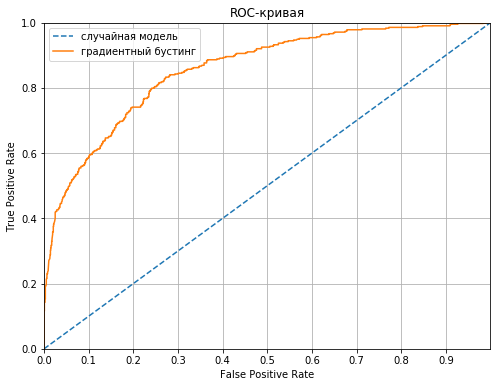

In [81]:
# график с ROC-кривой
model_dict = roc_auc_plot({'градиентный бустинг': model}, features_test, target_test)

- Нам удалось довести значение **метрики F1** до уровня **0.61** - модель прошла испытание **тестовой** выборкой.  
- Дополнительно мы построили **ROC-кривую** и вычислили **AUC-ROC - 0.86** - модель также продемонстрировала хорошие результаты.

## Шаг 3. Вывод

- В качестве финальной модели был выбран **градиентный бустинг** с гиперпараметрами ***'n_estimators': 200, 'min_child_weight': 0.02, 'learning_rate': 0.01, 'class_weight': 'balanced'***.
- Модель выдержала испытание **тестовой выборкой** - значение **F1** не упало ниже 0.59.
- Значение **AUC-ROC - 0.86** также не упало ниже значений, продемонстрированных на валидационной выборке.

# Итоговый вывод
    
## Шаг 1. Открытие и изучение файла

Мы ознакомились с полученными данными и провели предобработку:
### 1.1. Открытие файла
 - В исходных данных содержалось **10000 строк** и **14 столбцов**.
 - **Целевой признак** - колонка *Exited* (клиент ушёл - 1, не ушёл - 0). В выборке ушедшими является 20% клиентов (дисбаланс классов).
 - В колонке *Tenure* (количество недвижимости у клиента) были **пропуски**.
 
### 1.2. Проверка и изучение данных
 - Изучено распределение и особенности данных по колонкам.
 - **Удалены** колонки, которые не потребуются для обучения модели (*RowNumber*, *CustomerId*, *Surname*).
 - **Удалены** строки с **пропусками** в колонке *Tenure*.
    
### 1.3. Подготовка данных для обучения
 - Проведено **кодирование** данных в столбцах Geography и Gender с помощью техники **One-Hot Encoding**.
 - Выделены **признаки** и **целевой признак *Exited***.
 - Выборка разделена на **обучающую**, **тестовую** и **валидационную**.
 - Проведено **масштабирование** количественных признаков.  
    
 
## Шаг 2. Исследование моделей
- Были рассмотрены результаты **без учёта** и **с учётом** дисбаланса классов.
- Наилучшие результаты по *f1* были получены **при учёте дисбаланса классов**.
- В качестве устранения дисбаланса классов было рассмотрено два метода:
 - **Взвешивание классов** - укащание в гиперпараметрах ***'class_weight = balanced'***
 - **Upsampling** - увеличение количества редких элементов, в нашем случае в 4 раза

- В случае с **upsample** обратным эффектом было то, что модель сильно **переобучалась** - *f1* на обучающей выборке было заметно выше, чем на валидационной.
- Учёт баланса классов практически не повлиял на значения *AUC-ROC*.
- Наилучшие результаты во всех случаях продемонстрировала модель **градиентного бустинга**. Однако при методе *upsample* модель градиентного бустинга практически дословно выучивала ответы обучающей выборки.
- В качестве модели для финального тестирования выберем **градиентный бустинг** с гиперпараметрами: ***'n_estimators': 200, 'min_child_weight': 0.02, 'learning_rate': 0.01, 'class_weight': 'balanced'***.


## Шаг 3. Тестирование модели
- В качестве финальной модели был выбран **градиентный бустинг** с гиперпараметрами ***'n_estimators': 200, 'min_child_weight': 0.02, 'learning_rate': 0.01, 'class_weight': 'balanced'***.
- Модель выдержала испытание **тестовой выборкой** - значение **F1** не упало ниже 0.59.
- Значение **AUC-ROC - 0.86** также не упало ниже значений, продемонстрированных на валидационной выборке.